Names: Priti Kamat, SriVidya Yelluripati, Siddhant Bhadsavale

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

 Two moons with an invertible neural network
We repeat task 2 from exercise 02 with a normalizing flow. That is, use a RealNVP network to train a generative model p(x) for the two moons dataset. A RealNVP consists of coupling blocks, where the second half of the dimensions is transformed by a linear function whose coefficients depend on the first half. The coefficients are calculated with nested neural networks with two hidden layers (with ReLU activation) and a linear output layer (for the translation coefficient) resp. a linear layer followed by exp(tanh(˜s)) (for the scaling coefficient). The width of these internal networks is a hyperparameter and may be larger than the data dimension. The first half of the dimensionsis just forwared by a skip connection. After each coupling layer (except for the last), a random orthogonormal matrix is inserted to rotate the space, so that the skip connection is not always
applied to the same dimensions. 

The RealNVP's constructor should have three arguments:
input_size: the data dimension (= 2 for the two moons dataset)
hidden_size: the width of the nested networks
blocks: the number of coupling blocks

Implement the encoder as the forward pass through the network, and the decoder as the reverse
pass.

In [7]:
class CouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CouplingBlock, self).__init__()
        
        self.d_tilde = input_size // 2

        self.scale_network = nn.Sequential(
            nn.Linear(self.d_tilde, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.d_tilde),
            nn.Tanh(),
        )
        
        self.translation_network = nn.Sequential(
            nn.Linear(self.d_tilde, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, self.d_tilde),
        )

    def forward(self, x):
        x1 = x[:, :self.d_tilde] 
        x2 = x[:, self.d_tilde:] 
        
        z1 = x1

        s = self.scale_network(x1)
        t = self.translation_network(x1)
        z2 = torch.exp(torch.tanh(s)) * x2 + t

        z = torch.cat([z1, z2], dim=1)

        log_det_jacobian = torch.sum(torch.tanh(s), dim=1) 

        return z, log_det_jacobian
    
    def inverse(self, z):
        z1 = z[:, :self.d_tilde]
        z2 = z[:, self.d_tilde:]

        x1 = z1

        s = self.scale_network(x1)
        t = self.translation_network(x1)

        x2 = (z2 - t) * torch.exp(-1 * torch.tanh(s)) 
              
        x = torch.cat([x1, x2], dim=1)

        return x

# Define RealNVP class
class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks

        self.layers = nn.ModuleList([CouplingBlock(self.input_size, self.hidden_size) for _ in range(self.blocks)])
        
        self.orthonormal_matrices = []
        self.orthonormal_matrices_T = []
        for i in range(self.blocks-1):
            matrix = self._get_orthonormal_matrix(self.input_size)
            self.orthonormal_matrices.append(matrix)
            self.orthonormal_matrices_T.append(torch.transpose(matrix, 0, 1)) # for inverse pass (decoder)

    def _get_orthonormal_matrix(self, size):
        Q, _ = torch.linalg.qr(torch.randn(size, size))
        return nn.Parameter(Q, requires_grad=False)
        
    def encoder(self, x):
        log_det_jacobian_sum = 0
        for i in range(self.blocks):
            x, log_det_jacobian = self.layers[i](x)
            log_det_jacobian_sum += log_det_jacobian
            if i < self.blocks - 1:
                x = torch.matmul(x, self.orthonormal_matrices[i])
        return x, log_det_jacobian_sum
    
    def decoder(self, z):
        for i in range(self.blocks - 1, -1, -1):
            if i < self.blocks - 1:
                z = torch.matmul(z, self.orthonormal_matrices_T[i]) 
            z = self.layers[i].inverse(z)
        return z

    def forward(self, x):
        z, log_det_jacobian_sum = self.encoder(x)
        return z, log_det_jacobian_sum
    
    def sample(self, num_samples):
        z = torch.randn(num_samples, self.input_size)
        samples = self.decoder(z)
        return samples


Furthermore, implement a training function train_inn() (for "invertible neural network") using the torch.optim.Adam optimizer with default learning rate lr=0.001 and the negative log-likelihood loss, as explained in the lecture.

Training has again three hyperparameters:

the size of the training set,
the number of epochs,
and the learning rate.
During design and debugging of your code, your should start small (e.g. 1000 training points, 10 epochs, 2 layers) to ensure rapid training. Gradually increase network size and training effort once your results start looking promising. As a basic check, make sure that the reverse pass is the exact inverse of the forward pass, up to tiny numerical errors.

In [8]:
def custom_negative_log_likelihood_loss(model_outputs, log_det_jacobian_sum):
    return torch.mean(torch.sum(0.5 * torch.pow(model_outputs, 2), dim=1) - log_det_jacobian_sum)

# Training function for invertible neural network (INN)
def train_inn(model, X_train, X_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1, loss_function=custom_negative_log_likelihood_loss):
    criterion = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    data_test = torch.from_numpy(X_test).float()

    # loss before training
    with torch.no_grad():
        z, log_det_jacobian_sum = model(data_train)
        loss = criterion(z, log_det_jacobian_sum)
        train_losses.append(loss.item())
        z, log_det_jacobian_sum = model(data_test)
        loss = criterion(z, log_det_jacobian_sum)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    # training
    for epoch in range(n_epochs):
        train_loss = 0
        test_loss = 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            optimizer.zero_grad()
            z, log_det_jacobian_sum = model(data)
            loss = criterion(z, log_det_jacobian_sum)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                z, log_det_jacobian_sum = model(data)
                loss = criterion(z, log_det_jacobian_sum)
                test_loss += loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
            
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df


In [9]:
def get_moons_data(n_train, n_test=1000, noise=0.1, random_state=123):
    """
    Generate data from make_moons.
    """
    X_train, y_train = make_moons(n_samples=n_train, noise=noise, random_state=random_state)
    X_test, y_test = make_moons(n_samples=n_test, noise=noise, random_state=random_state+1)
    return X_train, y_train, X_test, y_test


In [10]:
# Plot model details
def plot_model_details(model, X_train, y_train, title="Model details"):
    with torch.no_grad():
        Z_train = model(torch.from_numpy(X_train).float())[0]
        X_decoded = model.decoder(Z_train)
        Z_train = Z_train.detach().numpy()
        Z_noise = torch.randn((1000, X_train.shape[1]))
        X_noise = model.decoder(Z_noise).detach().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    fig.suptitle(title, y=0.92)
    axs[0].scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, s=3)
    axs[0].set_title("Train set encoded")
    axs[0].set_aspect('equal')
    axs[1].scatter(X_decoded[:, 0], X_decoded[:, 1], c=y_train, s=3)
    axs[1].set_title("Train set decoded\nsame as original")
    axs[1].set_aspect('equal')
    axs[2].scatter(Z_noise[:, 0], Z_noise[:, 1], c="blue", s=3)
    axs[2].set_title("Gaussian random")
    axs[2].set_aspect('equal')
    axs[3].scatter(X_noise[:, 0], X_noise[:, 1], c="blue", s=3)
    axs[3].set_title("Noise decoded")
    axs[3].set_aspect('equal')
    plt.show()


In [11]:
def plot_training_losses(df, title="Training losses", starting_epoch=0):
    fig, ax = plt.subplots(figsize=(6, 4))
    fig.suptitle(title)
    ax.plot(df['epoch'], df['train'], label="Train")
    ax.plot(df['epoch'], df['test'], label="Test")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    max_val = max(df['train'][starting_epoch:].max(), df['test'][starting_epoch:].max())
    min_val = min(df['train'][starting_epoch:].min(), df['test'][starting_epoch:].min())
    ax.set_ylim(top=max_val,
                bottom=min_val - 0.1 * (max_val - min_val))
    ax.axvline(x=0, linestyle='--', color='gray')
    ax.legend(title="Loss")
    plt.show()


Epoch 0/1000: train_loss=0.7289, test_loss=0.7191
Epoch 101/1000: train_loss=-0.7784, test_loss=-0.7053
Epoch 202/1000: train_loss=-0.8467, test_loss=-0.7172
Epoch 303/1000: train_loss=-0.8532, test_loss=-0.6361
Epoch 404/1000: train_loss=-0.9026, test_loss=-0.7377
Epoch 505/1000: train_loss=-0.9200, test_loss=-0.7306
Epoch 606/1000: train_loss=-0.8943, test_loss=-0.5959
Epoch 707/1000: train_loss=-0.9354, test_loss=-0.7124
Epoch 808/1000: train_loss=-0.9481, test_loss=-0.7127
Epoch 909/1000: train_loss=-0.8668, test_loss=-0.6770
Epoch 1000/1000: train_loss=-0.8359, test_loss=-0.5327


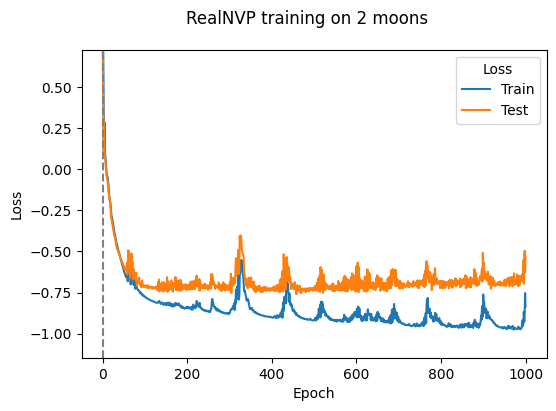

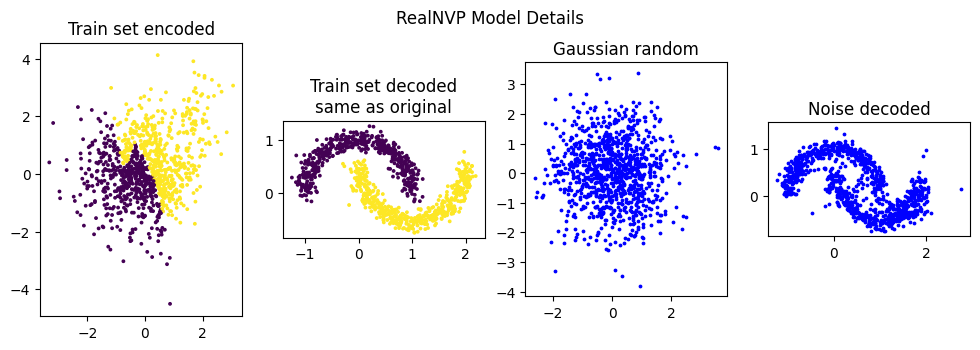

In [12]:
if __name__ == "__main__":
    # Get the data
    X_train, y_train, X_test, y_test = get_moons_data(1000, 200, noise=0.1)

    model = RealNVP(2, 128, 8)
    df = train_inn(model=model, X_train=X_train, X_test=X_test, 
                   n_epochs=1000, 
                   batch_size=1000, 
                   learning_rate=0.001)

    # Plot training losses
    plot_training_losses(df, title="RealNVP training on 2 moons", starting_epoch=0)

    # Plot model details
    plot_model_details(model, X_train, y_train, title="RealNVP Model Details")

In [13]:
from scipy.stats import shapiro
def check_distribution(model, X_train, y_train, title="Model details"):
    with torch.no_grad():
        Z_train = model(torch.from_numpy(X_train).float())[0]
        Z_train = Z_train.detach().numpy()
        Z_noise = torch.randn((X_train.shape[0], X_train.shape[1]))

    result_num = np.round(shapiro(Z_train).pvalue, 3)
    if result_num > 0.05:
        result = str(result_num) + ", is standard normal."
    else:
        result = str(result_num) + ", not standard normal."

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"{title} and Shapiro Wilk Test result: {result}", y=1)
    axs[0].scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, s=3)
    axs[0].set_title("Train set encoded")
    axs[0].set_aspect('equal')
    axs[1].scatter(Z_noise[:, 0], Z_noise[:, 1], c="blue", s=3)
    axs[1].set_title("Gaussian random")
    axs[1].set_aspect('equal')
    plt.show()


In [14]:
def investigate_hyperparams(training_set_size=1000, num_epochs=1000, lr=0.001):
    X_train, y_train, X_test, y_test = get_moons_data(training_set_size, 200, noise=0.1)
    model = RealNVP(2, 128, 8)
    df = train_inn(model=model, X_train=X_train, X_test=X_test, 
                   n_epochs=num_epochs, 
                   batch_size=training_set_size, 
                   learning_rate=lr)

    plot_training_losses(df, title=f"RealNVP training, train set size: {training_set_size}, epochs: {num_epochs}, lr: {lr}", starting_epoch=0)
    check_distribution(model, X_train, y_train, title="Model details")
    return model

Epoch 0/1000: train_loss=1.0401, test_loss=1.0440
Epoch 101/1000: train_loss=-0.7724, test_loss=-0.4195
Epoch 202/1000: train_loss=-0.7605, test_loss=-0.6931
Epoch 303/1000: train_loss=-0.8306, test_loss=-0.7165
Epoch 404/1000: train_loss=-0.8307, test_loss=-0.7560
Epoch 505/1000: train_loss=-0.8480, test_loss=-0.7624
Epoch 606/1000: train_loss=-0.8595, test_loss=-0.7410
Epoch 707/1000: train_loss=-0.8143, test_loss=-0.7459
Epoch 808/1000: train_loss=-0.8928, test_loss=-0.6905
Epoch 909/1000: train_loss=-0.8636, test_loss=-0.6327
Epoch 1000/1000: train_loss=-0.8993, test_loss=-0.6563


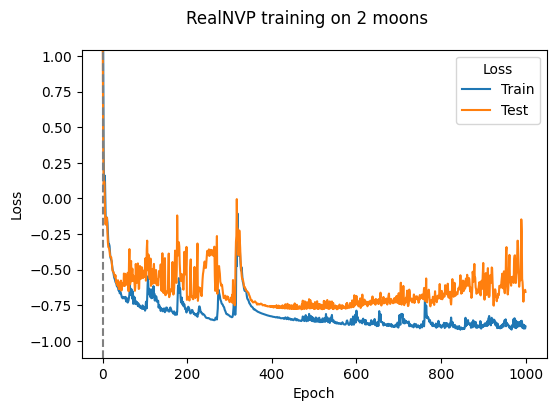

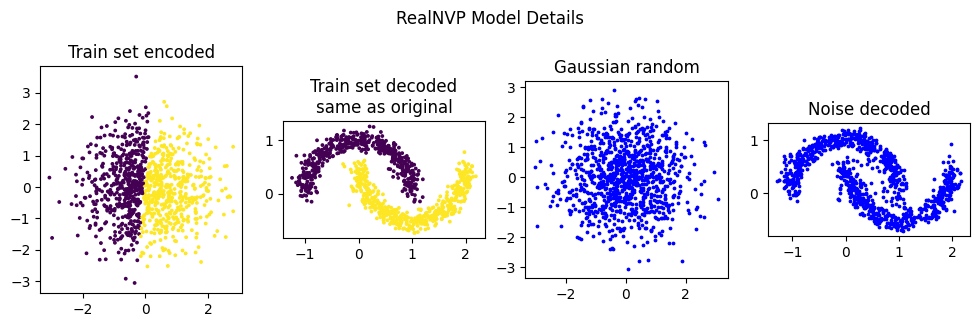

Start
Epoch 0/1000: train_loss=0.9034, test_loss=0.8952
Epoch 101/1000: train_loss=-0.9601, test_loss=0.5347
Epoch 202/1000: train_loss=-0.9495, test_loss=0.1626
Epoch 303/1000: train_loss=-1.1898, test_loss=1.0656
Epoch 404/1000: train_loss=-1.2301, test_loss=1.9144
Epoch 505/1000: train_loss=-0.9873, test_loss=-0.3552
Epoch 606/1000: train_loss=-1.2207, test_loss=0.5729
Epoch 707/1000: train_loss=-1.1682, test_loss=0.5403
Epoch 808/1000: train_loss=-1.2735, test_loss=0.3930
Epoch 909/1000: train_loss=-1.1880, test_loss=0.2784
Epoch 1000/1000: train_loss=-1.0711, test_loss=0.3909


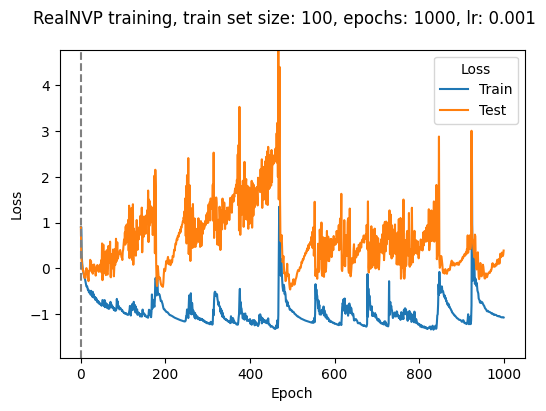

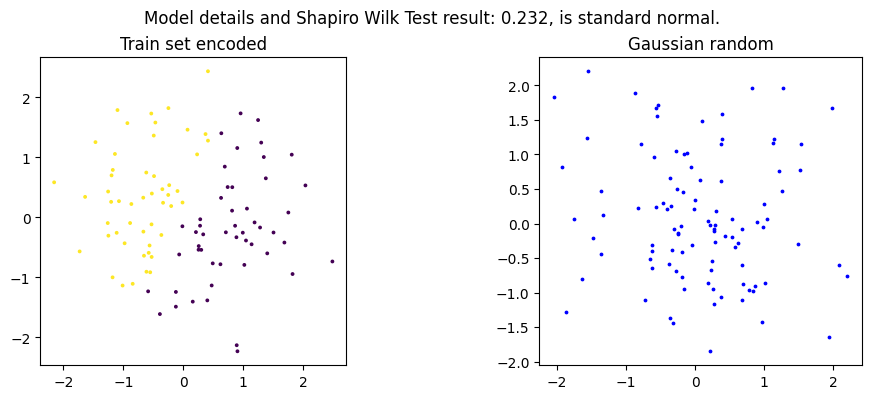

Done: 100
Epoch 0/1000: train_loss=0.6165, test_loss=0.6285
Epoch 101/1000: train_loss=-0.7146, test_loss=1.4919
Epoch 202/1000: train_loss=0.2707, test_loss=0.2039
Epoch 303/1000: train_loss=-0.9081, test_loss=-0.5372
Epoch 404/1000: train_loss=-1.0510, test_loss=-0.2958
Epoch 505/1000: train_loss=-0.7783, test_loss=-0.4159
Epoch 606/1000: train_loss=-1.1371, test_loss=0.1887
Epoch 707/1000: train_loss=-1.2070, test_loss=0.4035
Epoch 808/1000: train_loss=-1.2459, test_loss=0.7098
Epoch 909/1000: train_loss=-0.9178, test_loss=0.3380
Epoch 1000/1000: train_loss=-1.2756, test_loss=1.1123


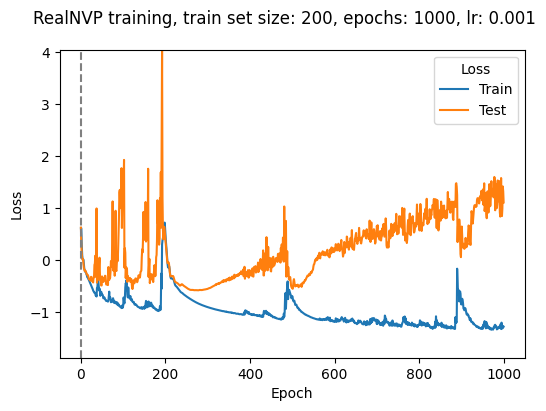

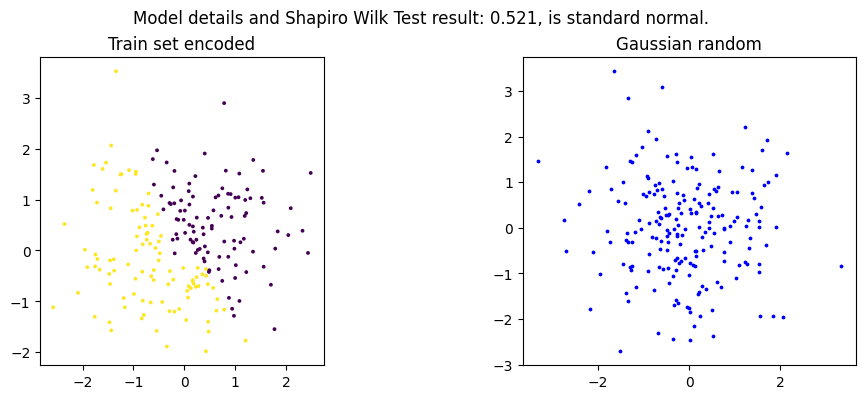

Done: 200
Epoch 0/1000: train_loss=1.1312, test_loss=1.1367
Epoch 101/1000: train_loss=-0.7687, test_loss=-0.6647
Epoch 202/1000: train_loss=-0.8480, test_loss=-0.7035
Epoch 303/1000: train_loss=-0.7706, test_loss=-0.7233
Epoch 404/1000: train_loss=-0.8879, test_loss=-0.7356
Epoch 505/1000: train_loss=-0.9093, test_loss=-0.7001
Epoch 606/1000: train_loss=-0.8915, test_loss=-0.7138
Epoch 707/1000: train_loss=-0.9248, test_loss=-0.6783
Epoch 808/1000: train_loss=-0.9664, test_loss=-0.6610
Epoch 909/1000: train_loss=-0.9845, test_loss=-0.6533
Epoch 1000/1000: train_loss=-0.9874, test_loss=-0.6430


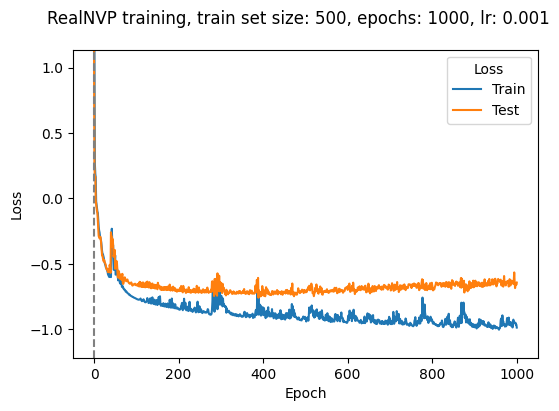

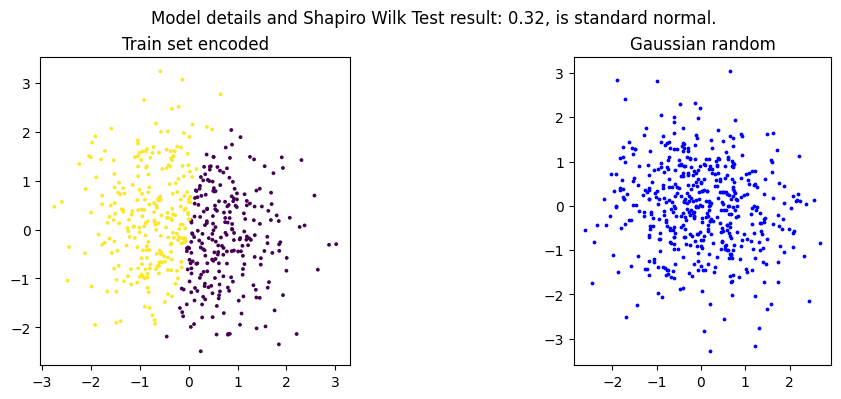

Done: 500
Epoch 0/1000: train_loss=0.9069, test_loss=0.9106
Epoch 101/1000: train_loss=-0.8216, test_loss=-0.6945
Epoch 202/1000: train_loss=-0.8540, test_loss=-0.6486
Epoch 303/1000: train_loss=-0.8944, test_loss=-0.6965
Epoch 404/1000: train_loss=-0.8954, test_loss=-0.6815
Epoch 505/1000: train_loss=-0.9209, test_loss=-0.6570
Epoch 606/1000: train_loss=-0.9008, test_loss=-0.6312
Epoch 707/1000: train_loss=-0.8983, test_loss=-0.5934
Epoch 808/1000: train_loss=-0.9314, test_loss=-0.6061
Epoch 909/1000: train_loss=-0.9532, test_loss=-0.6223
Epoch 1000/1000: train_loss=-0.9675, test_loss=-0.6316


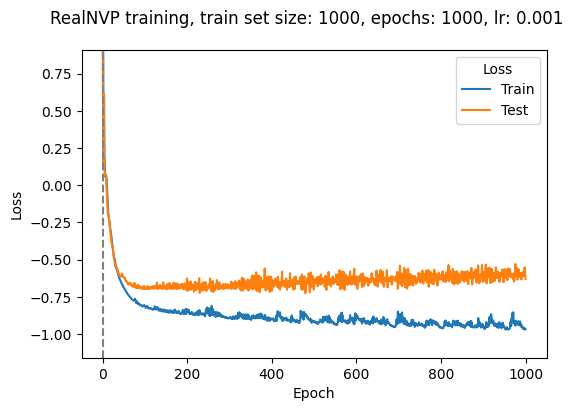

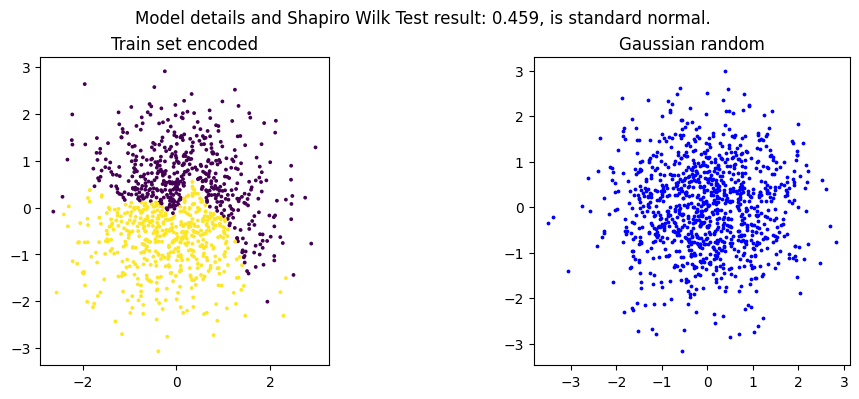

Done: 1000
Epoch 0/10: train_loss=0.9031, test_loss=0.9057
Epoch 2/10: train_loss=0.2967, test_loss=0.0768
Epoch 4/10: train_loss=0.3821, test_loss=0.0186
Epoch 6/10: train_loss=-0.0338, test_loss=-0.0321
Epoch 8/10: train_loss=-0.0287, test_loss=-0.0291
Epoch 10/10: train_loss=-0.0451, test_loss=-0.0741


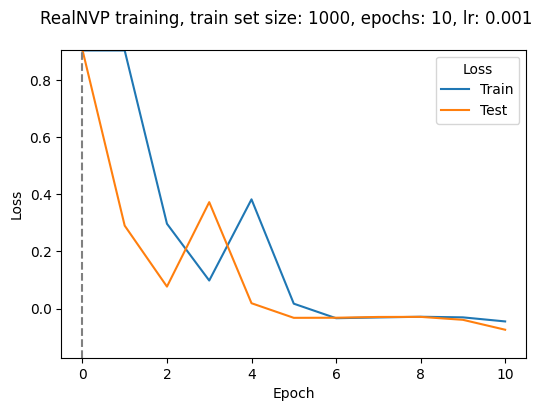

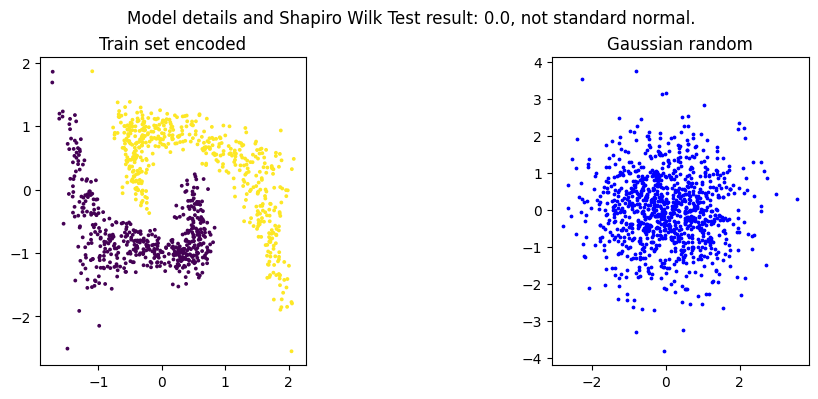

Done: 10
Epoch 0/50: train_loss=1.1031, test_loss=1.1055
Epoch 6/50: train_loss=0.2951, test_loss=0.2916
Epoch 12/50: train_loss=-0.0049, test_loss=-0.0599
Epoch 18/50: train_loss=-0.1842, test_loss=-0.1936
Epoch 24/50: train_loss=-0.2748, test_loss=-0.2558
Epoch 30/50: train_loss=-0.3571, test_loss=-0.3358
Epoch 36/50: train_loss=-0.4277, test_loss=-0.4096
Epoch 42/50: train_loss=-0.4889, test_loss=-0.4691
Epoch 48/50: train_loss=-0.5415, test_loss=-0.4939
Epoch 50/50: train_loss=-0.5516, test_loss=-0.5025


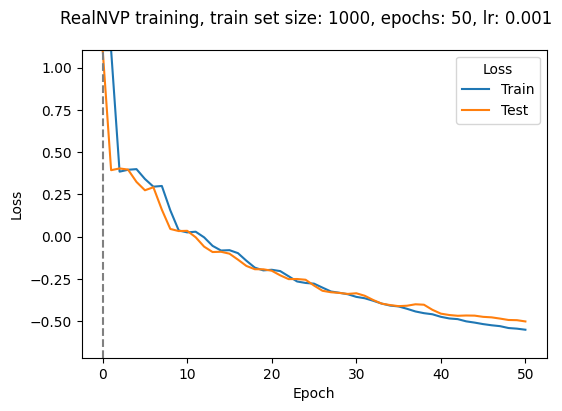

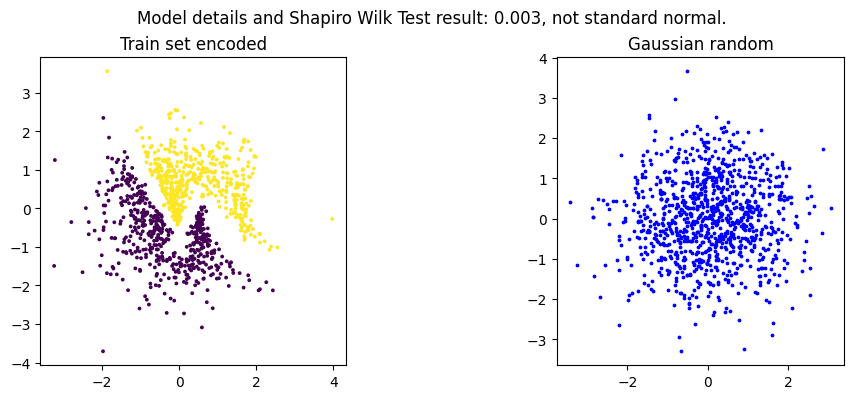

Done: 50
Epoch 0/100: train_loss=0.6990, test_loss=0.7117
Epoch 11/100: train_loss=-0.2108, test_loss=-0.2712
Epoch 22/100: train_loss=-0.4761, test_loss=-0.4794
Epoch 33/100: train_loss=-0.6278, test_loss=-0.5942
Epoch 44/100: train_loss=-0.6894, test_loss=-0.6516
Epoch 55/100: train_loss=-0.7259, test_loss=-0.6695
Epoch 66/100: train_loss=-0.7552, test_loss=-0.6939
Epoch 77/100: train_loss=-0.7866, test_loss=-0.6952
Epoch 88/100: train_loss=-0.8078, test_loss=-0.7311
Epoch 99/100: train_loss=-0.8251, test_loss=-0.7397
Epoch 100/100: train_loss=-0.8276, test_loss=-0.7363


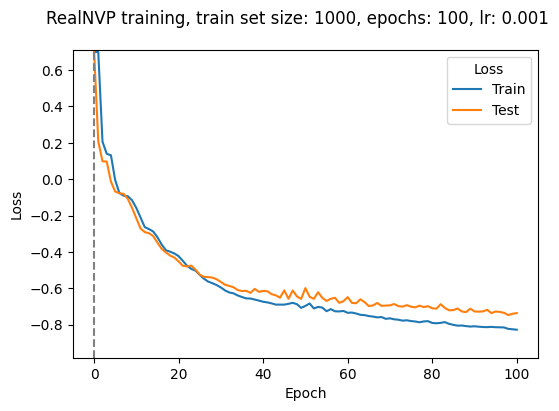

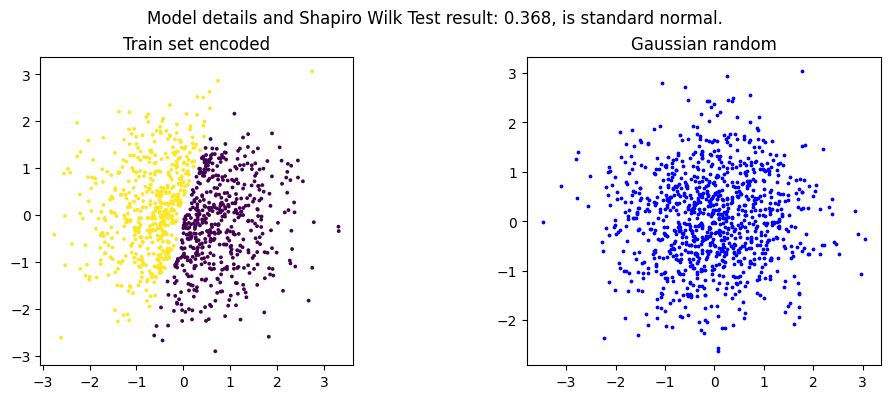

Done: 100
Epoch 0/200: train_loss=0.4443, test_loss=0.4452
Epoch 21/200: train_loss=-0.3857, test_loss=-0.3822
Epoch 42/200: train_loss=-0.5837, test_loss=-0.5806
Epoch 63/200: train_loss=-0.7381, test_loss=-0.6512
Epoch 84/200: train_loss=-0.6627, test_loss=-0.6780
Epoch 105/200: train_loss=-0.7906, test_loss=-0.6742
Epoch 126/200: train_loss=-0.8283, test_loss=-0.6626
Epoch 147/200: train_loss=-0.8476, test_loss=-0.6523
Epoch 168/200: train_loss=-0.7556, test_loss=-0.7106
Epoch 189/200: train_loss=-0.7968, test_loss=-0.7273
Epoch 200/200: train_loss=-0.8300, test_loss=-0.6558


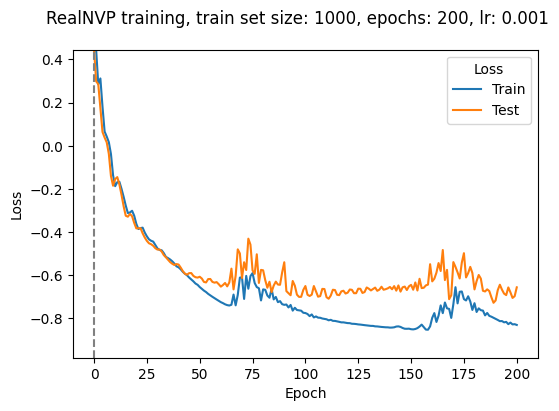

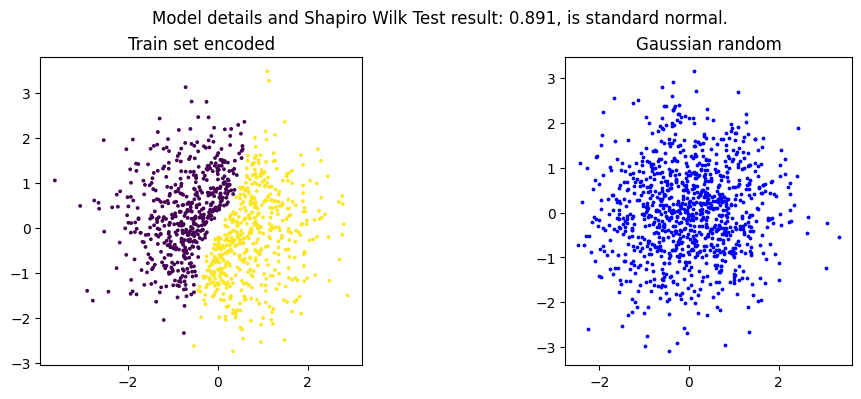

Done: 200
Epoch 0/1000: train_loss=0.7987, test_loss=0.7984
Epoch 101/1000: train_loss=-0.5063, test_loss=-0.5841
Epoch 202/1000: train_loss=-0.8133, test_loss=-0.6888
Epoch 303/1000: train_loss=-0.8336, test_loss=-0.6817
Epoch 404/1000: train_loss=-0.8493, test_loss=-0.7231
Epoch 505/1000: train_loss=-0.8508, test_loss=-0.7113
Epoch 606/1000: train_loss=-0.8495, test_loss=-0.7468
Epoch 707/1000: train_loss=-0.9037, test_loss=-0.7493
Epoch 808/1000: train_loss=-0.9187, test_loss=-0.7118
Epoch 909/1000: train_loss=-0.9187, test_loss=-0.6935
Epoch 1000/1000: train_loss=-0.9437, test_loss=-0.7393


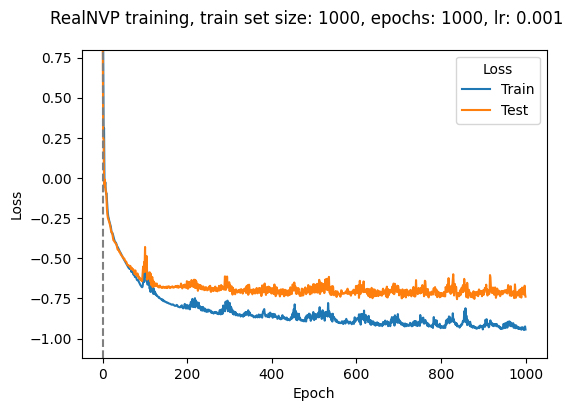

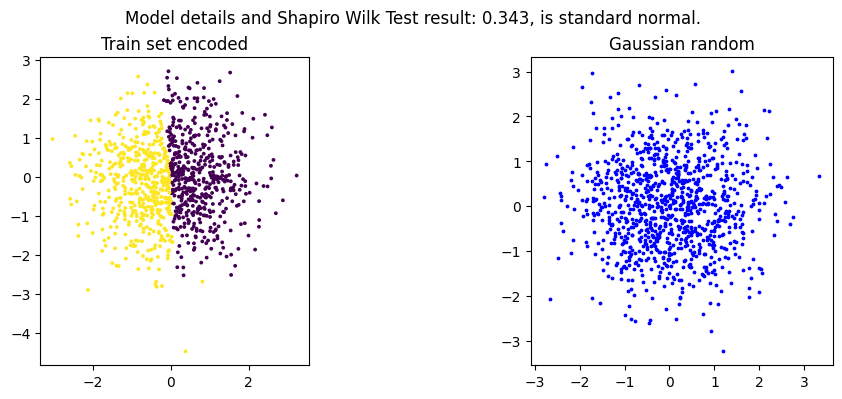

Done: 1000
Epoch 0/1000: train_loss=0.7916, test_loss=0.7983
Epoch 101/1000: train_loss=-0.6823, test_loss=-0.6609
Epoch 202/1000: train_loss=-0.7347, test_loss=-0.7895
Epoch 303/1000: train_loss=-0.8759, test_loss=-0.7392
Epoch 404/1000: train_loss=-0.9112, test_loss=-0.6896
Epoch 505/1000: train_loss=-0.9024, test_loss=-0.6286
Epoch 606/1000: train_loss=-0.9033, test_loss=-0.5908
Epoch 707/1000: train_loss=-0.9141, test_loss=-0.6134
Epoch 808/1000: train_loss=-0.9009, test_loss=-0.5419
Epoch 909/1000: train_loss=-0.9515, test_loss=-0.5227
Epoch 1000/1000: train_loss=-0.9307, test_loss=-0.5624


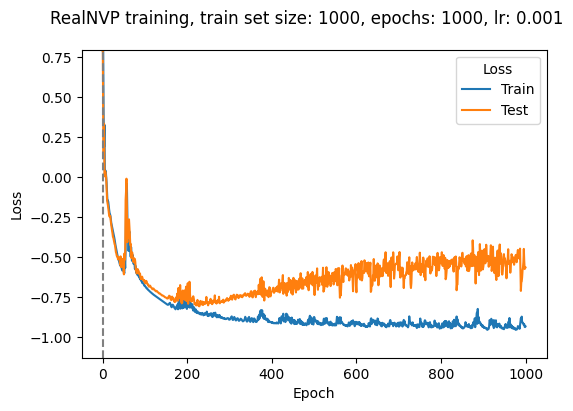

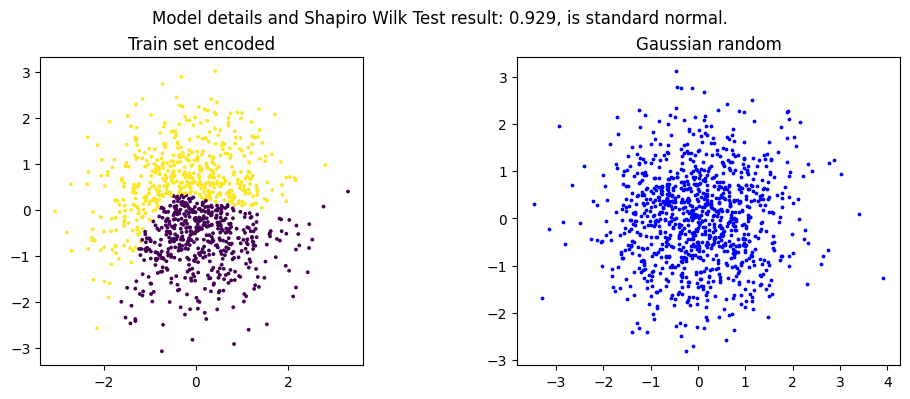

Done: 0.001
Epoch 0/1000: train_loss=0.6910, test_loss=0.6817
Epoch 101/1000: train_loss=-0.2557, test_loss=-0.2297
Epoch 202/1000: train_loss=-0.5949, test_loss=-0.4624
Epoch 303/1000: train_loss=-0.6560, test_loss=-0.4505
Epoch 404/1000: train_loss=-0.6689, test_loss=-0.5450
Epoch 505/1000: train_loss=-0.7235, test_loss=-0.5705
Epoch 606/1000: train_loss=-0.7069, test_loss=-0.5159
Epoch 707/1000: train_loss=-0.7606, test_loss=-0.5807
Epoch 808/1000: train_loss=-0.7553, test_loss=-0.5803
Epoch 909/1000: train_loss=-0.7045, test_loss=-0.5837
Epoch 1000/1000: train_loss=-0.7512, test_loss=-0.5270


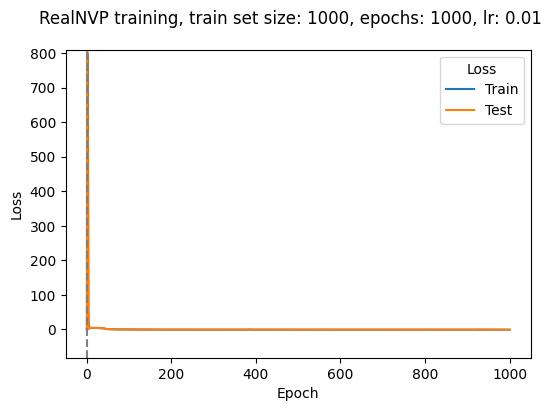

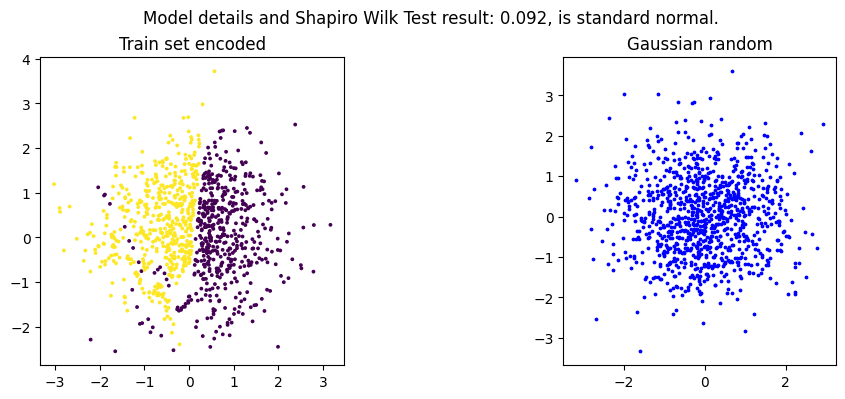

Done: 0.01
Epoch 0/1000: train_loss=0.6617, test_loss=0.6799
Epoch 101/1000: train_loss=7.7387, test_loss=7.7201
Epoch 202/1000: train_loss=5.1919, test_loss=5.2446
Epoch 303/1000: train_loss=4.7886, test_loss=4.8092
Epoch 404/1000: train_loss=4.5005, test_loss=4.5092
Epoch 505/1000: train_loss=4.2757, test_loss=4.2769
Epoch 606/1000: train_loss=4.0945, test_loss=4.0868
Epoch 707/1000: train_loss=3.8515, test_loss=3.8407
Epoch 808/1000: train_loss=3.5117, test_loss=3.4892
Epoch 909/1000: train_loss=3.3624, test_loss=3.3387
Epoch 1000/1000: train_loss=3.3247, test_loss=3.3062


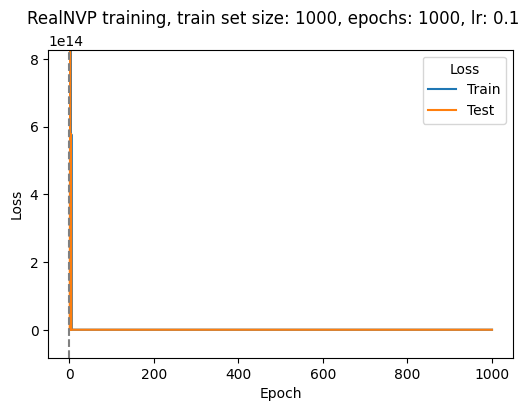

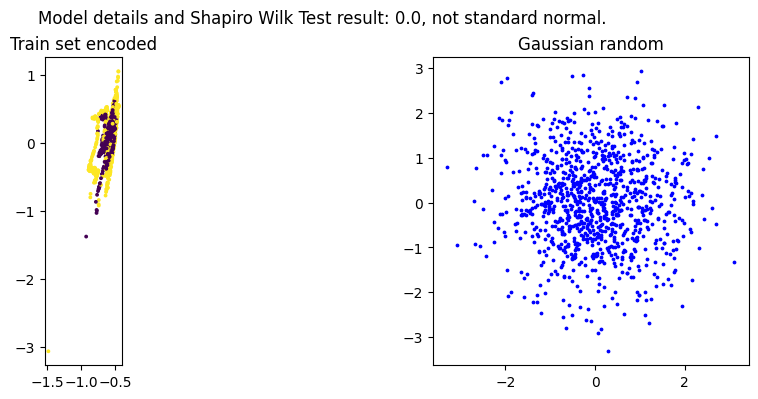

Done: 0.1
End


In [15]:
if __name__ == "__main__":
    # Get the data
    X_train, y_train, X_test, y_test = get_moons_data(1000, 200, noise=0.1)

   
    model = RealNVP(2, 128, 8)
    df = train_inn(model=model, X_train=X_train, X_test=X_test, 
                   n_epochs=1000, 
                   batch_size=1000, 
                   learning_rate=0.001)

    plot_training_losses(df, title="RealNVP training on 2 moons", starting_epoch=0)

    
    plot_model_details(model, X_train, y_train, title="RealNVP Model Details")

    
    size_training_set_list = [100, 200, 500, 1000]
    epochs_list = [10, 50, 100, 200, 1000]
    lr_list = [0.001, 0.01, 0.1]

    models_list = []
    print("Start")
    for size in size_training_set_list:
        model1 = investigate_hyperparams(training_set_size=size)
        models_list.append(model1)
        print(f"Done: {size}")

    for epoch in epochs_list:
        model1 = investigate_hyperparams(num_epochs=epoch)
        models_list.append(model1)
        print(f"Done: {epoch}")

    for lr in lr_list:
        model1 = investigate_hyperparams(lr=lr)
        models_list.append(model1)
        print(f"Done: {lr}")

    print("End")


The investigation showed that increasing the training set size improved model stability and generalization, with the largest set (1000 samples) yielding the most consistent convergence. Training for more epochs generally reduced losses, with diminishing returns beyond 500 epochs. Learning rates impacted stability; smaller rates (e.g., 0.001) led to smoother convergence, while higher rates caused fluctuations. Overall, larger training sets, moderate epochs, and smaller learning rates provided the best balance for effective model training.

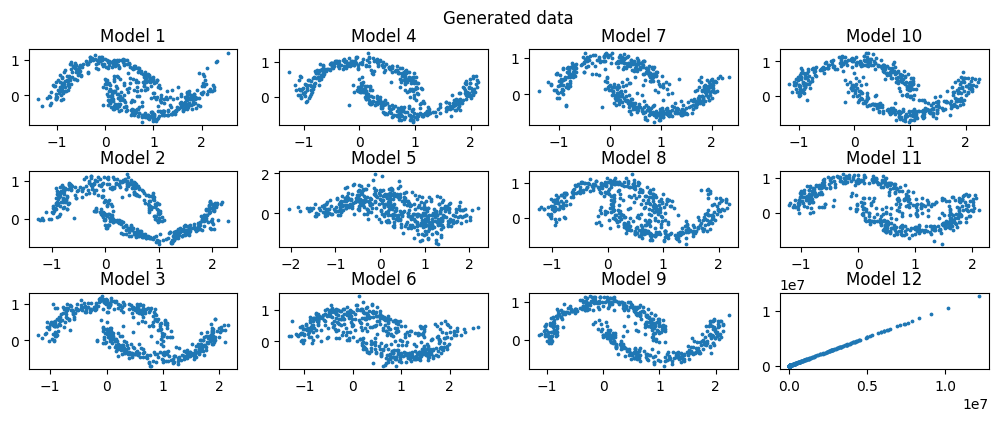

In [16]:
def plot_generated_data(models_list, num_sample=500, title="Generated data"):
    number_of_models = len(models_list)
    fig, axs = plt.subplots(3, 4, figsize=(12, 4))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.2, hspace=0.6)
    fig.suptitle(f"{title}", y=1)
    for i, model in enumerate(models_list):
        X_sampled = model.sample(num_samples=num_sample).detach().numpy()
        first = int(i / 3)
        second = i - first * 3
        axs[second][first].scatter(X_sampled[:, 0], X_sampled[:, 1], s=3)
        axs[second][first].set_title(f"Model {i+1}")
    plt.show()

# Plot generated data
plot_generated_data(models_list, num_sample=500, title="Generated data")


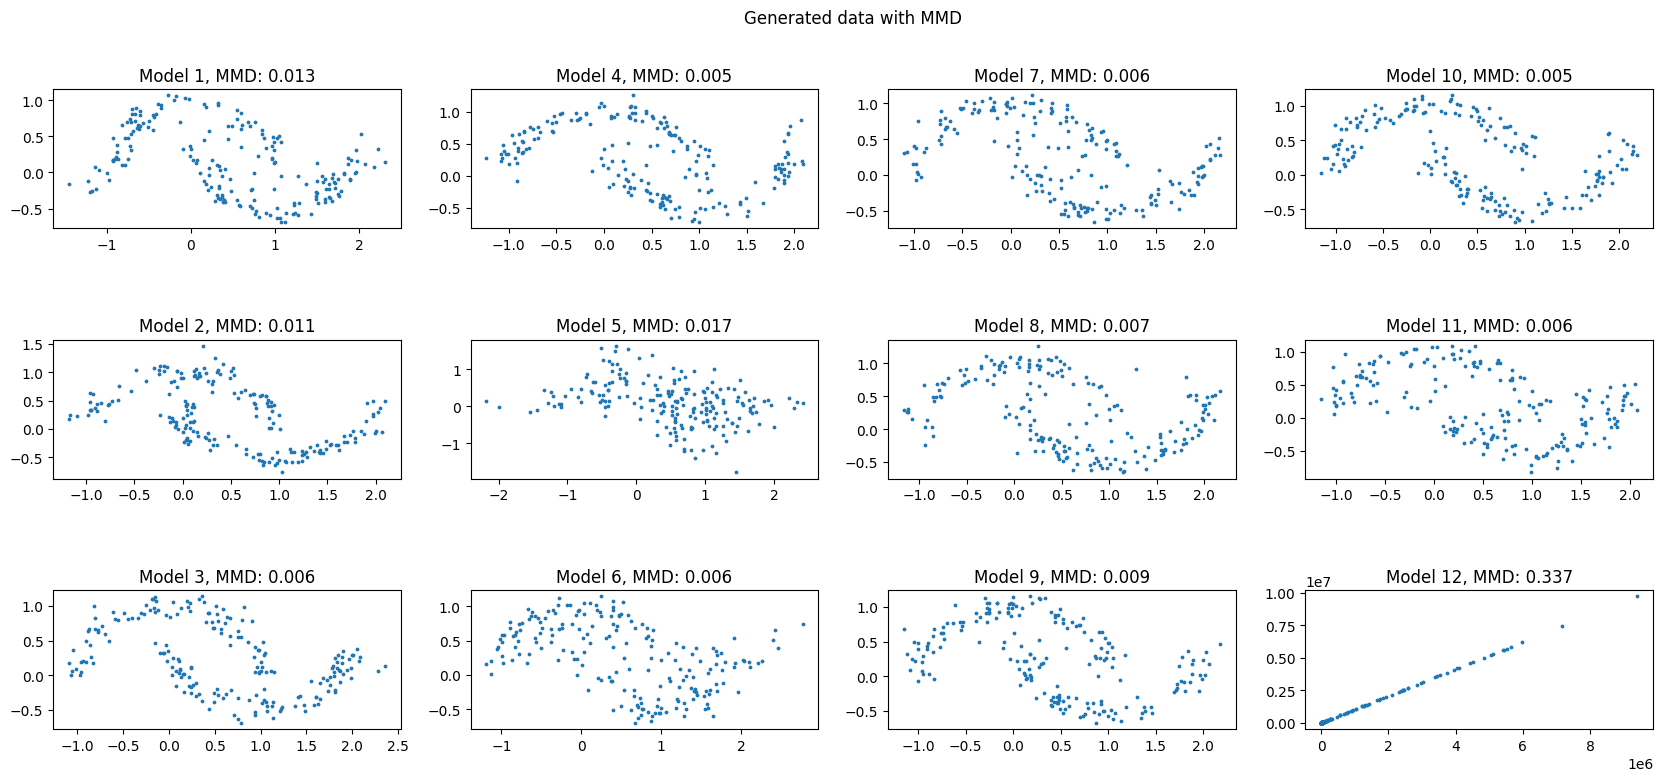

In [17]:
def mmd(dataset_1, dataset_2, bandwidth):
    """
    Function that calculates squared MMD metric.

    Args:
        dataset_1 (torch.Tensor): array of original points.
        dataset_2 (torch.Tensor): array of reconstructed points.
        bandwidth (float): bandwidth of kernel.
    """
    
    M = len(dataset_1)
    part_1 = 0

    for i in range(M):
        for j in range(M):
            part_1 += mmd_kernel_squared_exponential(dataset_1[i], dataset_1[j], bandwidth)
    part_1 /= M * (M - 1)

    N = len(dataset_2)
    part_2 = 0
    for i in range(N):
        for j in range(N):
            part_2 += mmd_kernel_squared_exponential(dataset_2[i], dataset_2[j], bandwidth)
    part_2 /= N * (N - 1)

    part_3 = 0
    for i in range(M):
        for j in range(N):
            part_3 += mmd_kernel_squared_exponential(dataset_1[i], dataset_2[j], bandwidth)
    part_3 *= 2 / (M * N)

    mmd_square = part_1 + part_2 - part_3

    return mmd_square

def mmd_kernel_squared_exponential(x,y,h):
    """
    Function that calculates squared exponential kernel.

    Args:
        x (torch.Tensor): point.
        y (torch.Tensor): point.
        h (float): bandwidth of kernel.
    """
    return  np.exp(-1 * np.linalg.norm(x - y) ** 2 / (2 * h) )

def plot_generated_data(models_list, X_test_set, title="Generated data"):
    num_sample = len(X_test_set)
    number_of_models = len(models_list)
    fig, axs = plt.subplots(3, 4, figsize=(20, 8))
    fig.subplots_adjust(left=0.1, bottom=0.1, top=0.9, wspace=0.2, hspace=0.8)
    fig.suptitle(f"{title}", y=1)
    for i, model in enumerate(models_list):
        X_sampled = model.sample(num_samples=num_sample).detach().numpy()
        first = int(i / 3)
        second = i - first * 3
        axs[second][first].scatter(X_sampled[:, 0], X_sampled[:, 1], s=3)
        mmd_data = np.round(mmd(X_test_set, X_sampled, 0.5), 3)
        axs[second][first].set_title(f"Model {i+1}, MMD: {mmd_data}")
    plt.show()

# Plot generated data with MMD calculation
plot_generated_data(models_list, X_test, title="Generated data with MMD")


 As expected, visually better results have smaller MMD. The last model has big MMD value and also the plot shows, the data are poorly reconstructed.
- For model 10, the two moons are clearly visible and the MMD value is 0.005, so really good.

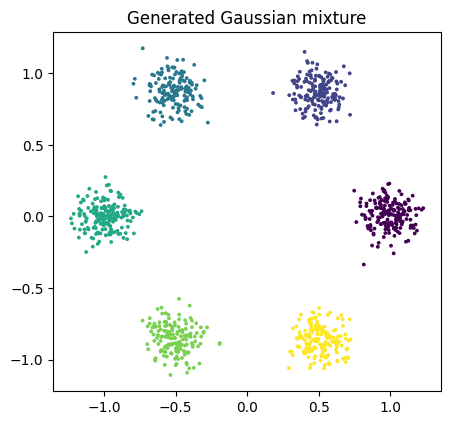

Epoch 0/1000: train_loss=0.4892, test_loss=0.4736
Epoch 101/1000: train_loss=-1.5070, test_loss=-1.5135
Epoch 202/1000: train_loss=-1.6046, test_loss=-1.5893
Epoch 303/1000: train_loss=-1.7345, test_loss=-1.5893
Epoch 404/1000: train_loss=-1.7856, test_loss=-1.6754
Epoch 505/1000: train_loss=-1.8014, test_loss=-1.6314
Epoch 606/1000: train_loss=-1.8065, test_loss=-1.6451
Epoch 707/1000: train_loss=-1.8570, test_loss=-1.6902
Epoch 808/1000: train_loss=-1.8496, test_loss=-1.6654
Epoch 909/1000: train_loss=-1.8088, test_loss=-1.6085
Epoch 1000/1000: train_loss=-1.8437, test_loss=-1.6117


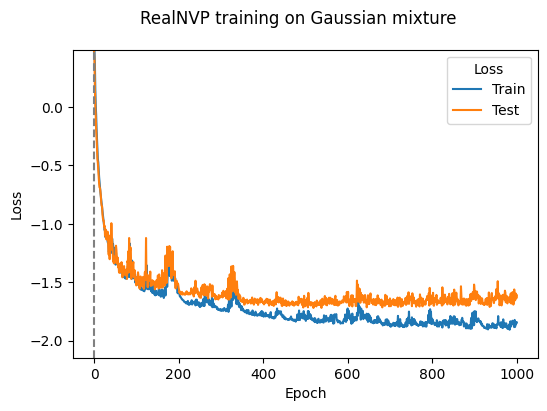

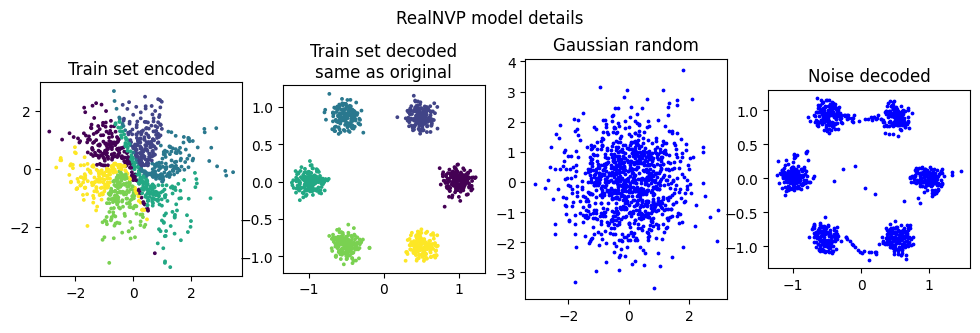

In [18]:
def get_hexagon_vertices(x=0, y=0, side=1):
    return [(x+side*np.cos(np.pi/3*i), y+side*np.sin(np.pi/3*i)) for i in range(6)]

def make_hexagon_gaussian_mixture(n_samples, noise=0.1):
    """
    Generate data from a mixture of 6 Gaussians.
    """
    hexagon_vertices = get_hexagon_vertices(x=0, y=0, side=1)
    X = []
    y = []
    for _ in range(n_samples):
        vertex_id = np.random.randint(6)
        X.append(np.random.normal(loc=hexagon_vertices[vertex_id], scale=noise))
        y.append(vertex_id)
    X = np.array(X)
    y = np.array(y)
    return X, y

if __name__ == "__main__":
    X_train_gm, y_train_gm = make_hexagon_gaussian_mixture(1000, noise=0.1)
    X_test_gm, y_test_gm = make_hexagon_gaussian_mixture(300, noise=0.1)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.title.set_text("Generated Gaussian mixture")
    ax.scatter(X_train_gm[:, 0], X_train_gm[:, 1], c=y_train_gm, s=3)
    ax.set_aspect('equal')
    plt.show()

    model_gm = RealNVP(2, 128, 8)
    df = train_inn(model=model_gm, X_train=X_train_gm, X_test=X_test_gm, 
                   n_epochs=1000, 
                   batch_size=1000,
                   learning_rate=0.001)

    plot_training_losses(df, title="RealNVP training on Gaussian mixture", starting_epoch=0)

    plot_model_details(model_gm, X_train_gm, y_train_gm, title="RealNVP model details")


The results show that the model performed somehow on this task, however, 2 moons dataset was easier to learn.

2 Two moons with a conditional invertible neural network
The function sklearn.datasets.make_moons also returns a label for the moon where each data point
belongs to, and your function to generate the GMM on the hexagon can easily be extended to
do this as well. We can use this information to train a conditional RealNVP for the conditional
distribution p(x | y) with y the label. Here, the nested networks receive a one-hot encoding of the
label as an additional input for both the forward and reverse passes through the RealNVP. Extend
the implementation from task 1 accordingly. The constructor needs a new argument condition_size,
and the encoder and decoder functions must now accept a condition of appropriate size.
Make sure that the generalized design works in vectorized mode. Especially, the extended function RealNVP.sample(self, num_samples, conditions) should generate num_sample points for every row of
condition

In [19]:
class CouplingBlockConditional(nn.Module):
    def __init__(self, input_size, hidden_size, condition_size):
        super(CouplingBlockConditional, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.condition_size = condition_size
        self.d_tilde = input_size // 2
        
        self.scale_network = nn.Sequential(
            nn.Linear(self.d_tilde + self.condition_size, self.hidden_size), 
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.d_tilde),
            nn.Tanh(),
        )
        
        self.translation_network = nn.Sequential(
            nn.Linear(self.d_tilde + self.condition_size, self.hidden_size), 
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.d_tilde),
        )

    def forward(self, x, y):
        x1 = x[:, :self.d_tilde]
        x2 = x[:, self.d_tilde:] 
        
        z1 = x1

        x1_y = torch.cat([x1, y], dim=1) 

        s = self.scale_network(x1_y)
        t = self.translation_network(x1_y)
        z2 = torch.exp(torch.tanh(s)) * x2 + t

        z = torch.cat([z1, z2], dim=1)

        log_det_jacobian = torch.sum(torch.tanh(s), dim=1) 

        return z, log_det_jacobian
    
    def inverse(self, z, y):
        z1 = z[:, :self.d_tilde]
        z2 = z[:, self.d_tilde:]

        x1 = z1

        x1_y = torch.cat([z1, y], dim=1) 
        s = self.scale_network(x1_y)
        t = self.translation_network(x1_y)

        x2 = (z2 - t) * torch.exp(-1 * torch.tanh(s)) 
              
        x = torch.cat([x1, x2], dim=1)

        return x

class RealNVP_Conditional(nn.Module):
    def __init__(self, input_size, hidden_size, blocks, condition_size):
        super(RealNVP_Conditional, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks
        self.condition_size = condition_size

        self.layers = nn.ModuleList([CouplingBlockConditional(self.input_size, self.hidden_size, self.condition_size)
                                     for _ in range(self.blocks)])
        
        self.orthonormal_matrices = []
        self.orthonormal_matrices_T = []
        for i in range(self.blocks-1):
            matrix = self._get_orthonormal_matrix(self.input_size)
            self.orthonormal_matrices.append(matrix)
            self.orthonormal_matrices_T.append(torch.transpose(matrix, 0, 1)) # for inverse pass (decoder)

    def _get_orthonormal_matrix(self, size):
        Q, _ = torch.qr(torch.randn(size, size))
        return nn.Parameter(Q, requires_grad=False)
        
    def encoder(self, x, y_onehotencoded_conditions):
        log_det_jacobian_sum = 0
        for i in range(self.blocks):
            x, log_det_jacobian = self.layers[i](x, y_onehotencoded_conditions)
            log_det_jacobian_sum += log_det_jacobian
            if i < self.blocks - 1:
                x = torch.matmul(x, self.orthonormal_matrices[i])
        return x, log_det_jacobian_sum
    
    def decoder(self, z, y_onehotencoded_conditions):
        for i in range(self.blocks - 1, -1, -1):
            if i < self.blocks - 1:
                z = torch.matmul(z, self.orthonormal_matrices_T[i]) # use transposed orthonormal matrix to undo its effect
            z = self.layers[i].inverse(z, y_onehotencoded_conditions)
        return z

    def forward(self, x, y_onehotencoded_conditions):
        z, log_det_jacobian_sum = self.encoder(x, y_onehotencoded_conditions)
        return z, log_det_jacobian_sum
    
    def sample(self, num_samples, conditions):
        conditions = torch.from_numpy(conditions).float()
        outputs = []
        for y_onehotencoded_condition in conditions:
            z = torch.randn(num_samples, self.input_size)
            y_repeated = y_onehotencoded_condition.repeat(num_samples, 1)
            samples = self.decoder(z, y_repeated)
            outputs.append(samples)
        outputs = torch.cat(outputs, dim=0)
        return outputs


In [20]:
def train_inn_conditional(model, X_train, X_test, y_train, y_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1, loss_function=custom_negative_log_likelihood_loss):
    criterion = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    y_train = y_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    y_onehotencoded_conditions_train = torch.eye(model.condition_size)[y_train.long()].float()  # One-hot encode y
    data_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    y_onehotencoded_conditions_test = torch.eye(model.condition_size)[y_test.long()].float()  # One-hot encode y

    with torch.no_grad():
        z, log_det_jacobian_sum = model(data_train, y_onehotencoded_conditions_train)
        loss = criterion(z, log_det_jacobian_sum)
        train_losses.append(loss.item())
        z, log_det_jacobian_sum = model(data_test, y_onehotencoded_conditions_test)
        loss = criterion(z, log_det_jacobian_sum)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")

    for epoch in range(n_epochs):
        train_loss = 0
        test_loss = 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            y_data = y_onehotencoded_conditions_train[i:i+batch_size]  # One-hot encoded y
            optimizer.zero_grad()
            z, log_det_jacobian_sum = model(data, y_data)
            loss = criterion(z, log_det_jacobian_sum)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                y_data = y_onehotencoded_conditions_test[i:i+batch_size]  # One-hot encoded y
                z, log_det_jacobian_sum = model(data, y_data)
                loss = criterion(z, log_det_jacobian_sum)
                test_loss += loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
            
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df


In [21]:
def plot_model_details_conditional(model, X_train, y_train, title="Model details"):
    y_onehotencoded_conditions = torch.eye(model.condition_size)[torch.from_numpy(y_train).long()].float()  # One-hot encode y
    with torch.no_grad():
        Z_train = model(torch.from_numpy(X_train).float(), y_onehotencoded_conditions)[0]
        X_decoded = model.decoder(Z_train, y_onehotencoded_conditions)
        Z_train = Z_train.detach().numpy()

        Z_noise = torch.randn((1000, X_train.shape[1]))
        y_rand = torch.randint(0, model.condition_size, (1000,))
        y_onehotencoded_conditions_rand = torch.eye(model.condition_size)[y_rand.long()].float()  # One-hot encode y
        X_noise = model.decoder(Z_noise, y_onehotencoded_conditions_rand).detach().numpy()

    fig, axs = plt.subplots(1, 4, figsize=(12, 4))
    fig.suptitle(title, y=0.92)
    axs[0].scatter(Z_train[:, 0], Z_train[:, 1], c=y_train, s=3)
    axs[0].set_title("Train set encoded")
    axs[0].set_aspect('equal')
    axs[1].scatter(X_decoded[:, 0], X_decoded[:, 1], c=y_train, s=3)
    axs[1].set_title("Train set decoded\nsame as original")
    axs[1].set_aspect('equal')
    axs[2].scatter(Z_noise[:, 0], Z_noise[:, 1], c=y_rand, s=3)
    axs[2].set_title("Gaussian random")
    axs[2].set_aspect('equal')
    axs[3].scatter(X_noise[:, 0], X_noise[:, 1], c=y_rand, s=3)
    axs[3].set_title("Noise decoded")
    axs[3].set_aspect('equal')
    plt.show()


Epoch 0/100: train_loss=0.4601, test_loss=0.4534
Epoch 11/100: train_loss=-0.8589, test_loss=-0.8486
Epoch 22/100: train_loss=-1.1406, test_loss=-1.1560
Epoch 33/100: train_loss=-1.3771, test_loss=-1.2479
Epoch 44/100: train_loss=-1.4687, test_loss=-1.4311
Epoch 55/100: train_loss=-1.5282, test_loss=-1.4186
Epoch 66/100: train_loss=-1.5457, test_loss=-1.4475
Epoch 77/100: train_loss=-1.5597, test_loss=-1.4795
Epoch 88/100: train_loss=-1.5689, test_loss=-1.4777
Epoch 99/100: train_loss=-1.4592, test_loss=-1.4596
Epoch 100/100: train_loss=-1.5140, test_loss=-1.4803


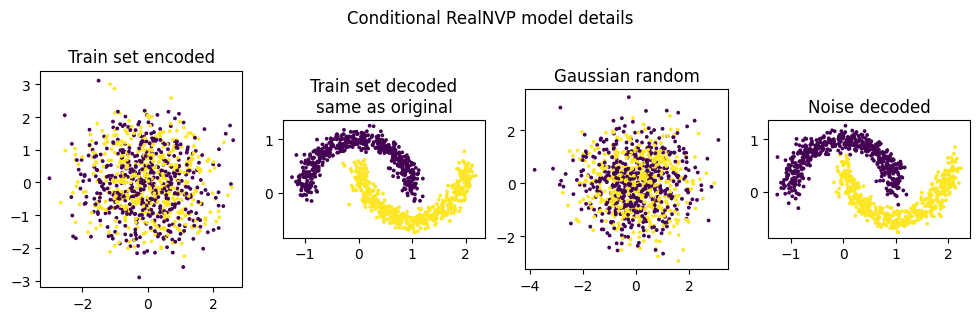

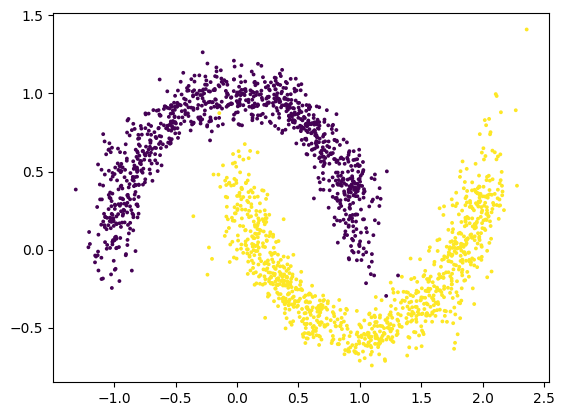

Epoch 0/100: train_loss=0.6499, test_loss=0.6502
Epoch 11/100: train_loss=-1.9589, test_loss=-2.1372
Epoch 22/100: train_loss=-3.2818, test_loss=-3.3496
Epoch 33/100: train_loss=-3.6130, test_loss=-3.6362
Epoch 44/100: train_loss=-3.6414, test_loss=-3.6302
Epoch 55/100: train_loss=-3.6668, test_loss=-3.6521
Epoch 66/100: train_loss=-3.6777, test_loss=-3.6568
Epoch 77/100: train_loss=-3.6773, test_loss=-3.6541
Epoch 88/100: train_loss=-3.6887, test_loss=-3.6546
Epoch 99/100: train_loss=-3.6924, test_loss=-3.6572
Epoch 100/100: train_loss=-3.6932, test_loss=-3.6564


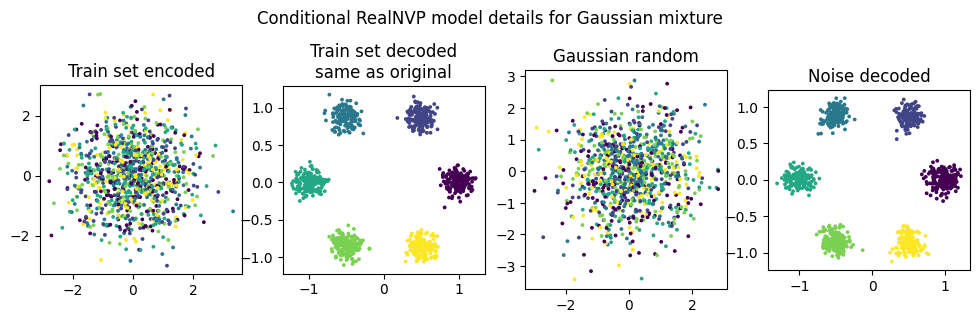

In [23]:
if __name__ == "__main__":
    X_train, y_train, X_test, y_test = get_moons_data(1000, 200, noise=0.1)

  
    model = RealNVP_Conditional(input_size=2, hidden_size=128, blocks=8, condition_size=2)
    df = train_inn_conditional(model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
                   n_epochs=100, 
                   batch_size=1000,
                   learning_rate=0.001)

   
    plot_model_details_conditional(model, X_train, y_train, title="Conditional RealNVP model details")

   
    N = 1000
    conditions_values = np.array([0, 1])
    conditions_onehotencoded = np.eye(2)[conditions_values]

    
    X_sampled = model.sample(num_samples=N, conditions=conditions_onehotencoded).detach().numpy()
    conditions_values_repeated = np.repeat(conditions_values, N)
    plt.scatter(X_sampled[:, 0], X_sampled[:, 1], s=3, c=conditions_values_repeated)
    plt.show()

   
    model_gm_task2 = RealNVP_Conditional(input_size=2, hidden_size=128, blocks=8, condition_size=6)
    df_gm = train_inn_conditional(model=model_gm_task2, X_train=X_train_gm, X_test=X_test_gm, y_train=y_train_gm, y_test=y_test_gm,
                   n_epochs=100, 
                   batch_size=1000,
                   learning_rate=0.001)

    plot_model_details_conditional(model_gm_task2, X_train_gm, y_train_gm, title="Conditional RealNVP model details for Gaussian mixture")


Epoch 0/100: train_loss=0.5699, test_loss=0.5812
Epoch 11/100: train_loss=-0.9645, test_loss=-0.9857
Epoch 22/100: train_loss=-1.3538, test_loss=-1.3658
Epoch 33/100: train_loss=-1.6529, test_loss=-1.6463
Epoch 44/100: train_loss=-1.9260, test_loss=-1.8969
Epoch 55/100: train_loss=-2.1408, test_loss=-2.0760
Epoch 66/100: train_loss=-2.1974, test_loss=-2.0561
Epoch 77/100: train_loss=-2.3042, test_loss=-2.1363
Epoch 88/100: train_loss=-2.3334, test_loss=-2.1401
Epoch 99/100: train_loss=-2.3150, test_loss=-2.1587
Epoch 100/100: train_loss=-2.3569, test_loss=-2.1642


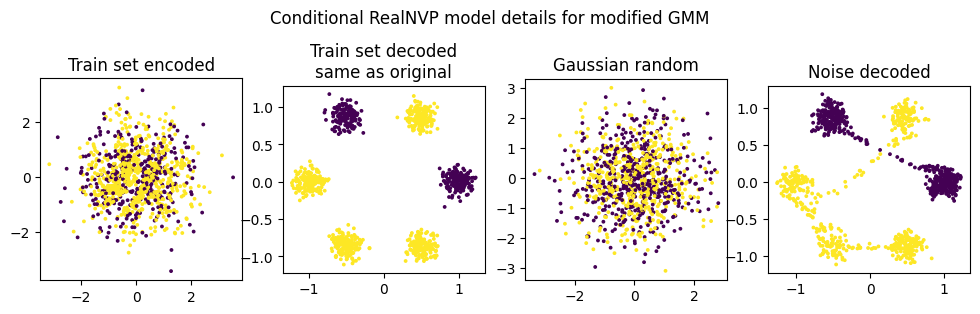

In [25]:
import copy


y_train_gm2 = copy.deepcopy(y_train_gm)
y_test_gm2 = copy.deepcopy(y_test_gm)


y_train_gm2[y_train_gm2 == 2] = 0
y_test_gm2[y_test_gm2 == 2] = 0

y_train_gm2[y_train_gm2 == 5] = 1
y_train_gm2[y_train_gm2 == 3] = 1
y_train_gm2[y_train_gm2 == 4] = 1

y_test_gm2[y_test_gm2 == 5] = 1
y_test_gm2[y_test_gm2 == 3] = 1
y_test_gm2[y_test_gm2 == 4] = 1


model_gm2 = RealNVP_Conditional(input_size=2, hidden_size=128, blocks=8, condition_size=2)
df_gm2 = train_inn_conditional(model=model_gm2, X_train=X_train_gm, X_test=X_test_gm, y_train=y_train_gm2, y_test=y_test_gm2,
               n_epochs=100, 
               batch_size=1000,
               learning_rate=0.001)

plot_model_details_conditional(model_gm2, X_train_gm, y_train_gm2, title="Conditional RealNVP model details for modified GMM")


In [26]:
import copy


def evaluate_conditional_mode(model, X_test, y_test, which_label=0):
    y_test_class_3 = copy.deepcopy(y_test)
    X_test_class_3 = copy.deepcopy(X_test)
    mask = (y_test_class_3 == which_label)
    y_test_class_3 = y_test_class_3[mask]
    X_test_class_3 = X_test_class_3[mask]
    
    conditions_values = np.zeros(len(set(y_test)))
    conditions_values[which_label] = 1
    conditions_all = np.array(conditions_values)
    conditions_all = conditions_all.reshape(-1, len(set(y_test)))

    X_sampled = model.sample(num_samples=len(X_test_class_3), conditions=conditions_all).detach().numpy()
    mmd_of_label = mmd(X_test_class_3, X_sampled, 0.5)

    return mmd_of_label, X_sampled


mmd0_2m, samples0_2m = evaluate_conditional_mode(model, X_test, y_test, which_label=0)
mmd1_2m, samples1_2m = evaluate_conditional_mode(model, X_test, y_test, which_label=1)

print(f"MMD for class 0: {mmd0_2m}.")
print(f"MMD for class 1: {mmd1_2m}.")


mmd0, samples0 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=0)
mmd1, samples1 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=1)
mmd2, samples2 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=2)
mmd3, samples3 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=3)
mmd4, samples4 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=4)
mmd5, samples5 = evaluate_conditional_mode(model_gm_task2, X_test_gm, y_test_gm, which_label=5)


MMD for class 0: 0.01497979455123477.
MMD for class 1: 0.01573227565239843.


In [27]:
print(f"MMD for class 0: {mmd0}.")
print(f"MMD for class 1: {mmd1}.")
print(f"MMD for class 2: {mmd2}.")
print(f"MMD for class 3: {mmd3}.")
print(f"MMD for class 4: {mmd4}.")
print(f"MMD for class 5: {mmd5}.")

MMD for class 0: 0.04679254029873703.
MMD for class 1: 0.04608024198713134.
MMD for class 2: 0.03900565908894871.
MMD for class 3: 0.03734287221918864.
MMD for class 4: 0.0350418847881242.
MMD for class 5: 0.03788678729511119.


In [28]:
model_2m_1 = RealNVP(2, 128, 8)
df = train_inn(model=model_2m_1, X_train=X_train, X_test=X_test, 
            n_epochs=200, 
            batch_size=1000,
            learning_rate=0.001)

Epoch 0/200: train_loss=0.6546, test_loss=0.6514
Epoch 21/200: train_loss=-0.4868, test_loss=-0.4854
Epoch 42/200: train_loss=-0.5409, test_loss=-0.5209
Epoch 63/200: train_loss=-0.7227, test_loss=-0.4609
Epoch 84/200: train_loss=-0.7730, test_loss=-0.5662
Epoch 105/200: train_loss=-0.7991, test_loss=-0.5789
Epoch 126/200: train_loss=-0.7474, test_loss=-0.6142
Epoch 147/200: train_loss=-0.6178, test_loss=-0.4443
Epoch 168/200: train_loss=-0.7856, test_loss=-0.6599
Epoch 189/200: train_loss=-0.8357, test_loss=-0.6940
Epoch 200/200: train_loss=-0.8473, test_loss=-0.6944


In [29]:

samplesmerged_2m=np.concatenate([samples0_2m, samples1_2m])

N = 300
X_sampled_2m = model_2m_1.sample(num_samples=N).detach().numpy()

mmd(samplesmerged_2m, X_sampled_2m, 0.5)

0.010470655373295723

In [30]:
labels0_2m = np.zeros(len(samples0_2m))
labels1_2m = np.ones(len(samples1_2m))
samples_labels_2m=np.concatenate([labels0_2m, labels1_2m])

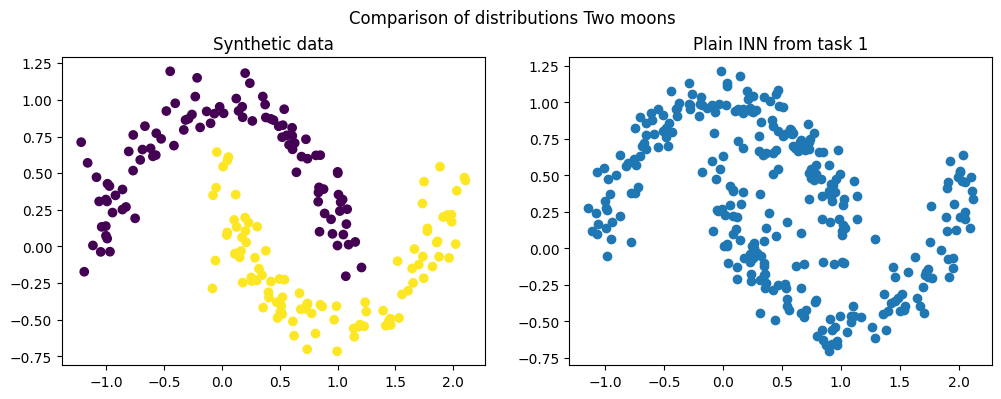

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Comparison of distributions Two moons", y=1)
axs[0].scatter(samplesmerged_2m[:,0], samplesmerged_2m[:,1], c=samples_labels_2m)
axs[0].set_title("Synthetic data")
axs[1].scatter(X_sampled_2m[:,0], X_sampled_2m[:,1])
axs[1].set_title("Plain INN from task 1")
plt.show()

In [32]:
samplesmerged=np.concatenate([samples0, samples1, samples2, samples3, samples4, samples5])

N = 300
X_sampled = model_gm.sample(num_samples=N).detach().numpy()

mmd(samplesmerged, X_sampled, 0.5)

0.0069359744870954865

In [33]:
labels0 = np.zeros(len(samples0))
labels1 = np.ones(len(samples1))
labels2 = 2* np.ones(len(samples2))
labels3 = 3*np.ones(len(samples3))
labels4 = 4*np.ones(len(samples4))
labels5 = 5*np.ones(len(samples5))
samples_labels=np.concatenate([labels0, labels1, labels2, labels3, labels4, labels5])

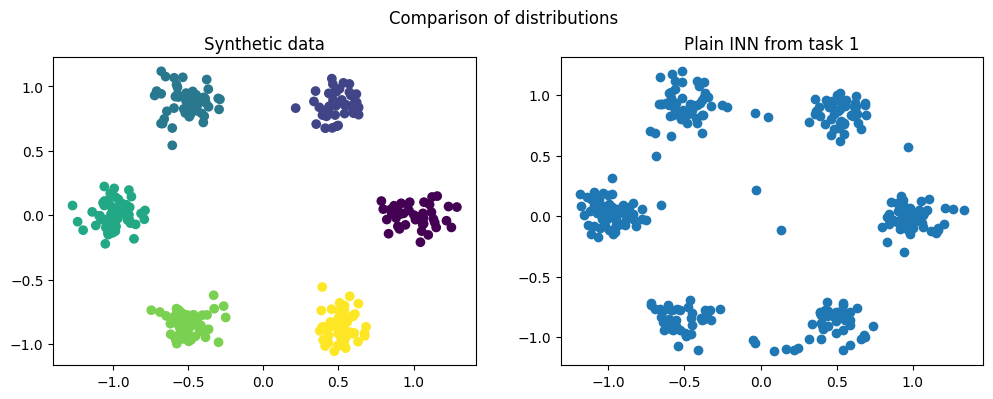

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle("Comparison of distributions", y=1)
axs[0].scatter(samplesmerged[:,0], samplesmerged[:,1], c=samples_labels)
axs[0].set_title("Synthetic data")
axs[1].scatter(X_sampled[:,0], X_sampled[:,1])
axs[1].set_title("Plain INN from task 1")
plt.show()

The quality of the conditional INN seems to be better than the one from task 1.

In [42]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
def get_digits_data():
    digits = load_digits()
    X = digits.data
    y = digits.target
    return X, y

X, y = get_digits_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1617, 64), (1617,), (180, 64), (180,))

In [43]:

def plot_model_details_pca(model, X_train, y_train, X_test, y_test, title="Some model"):
    with torch.no_grad():
        Z_train = model(torch.from_numpy(X_train).float())[0]
        X_decoded = model.decoder(Z_train).detach().numpy()
        Z_train = Z_train.detach().numpy()
        Z_train_pca = PCA(n_components=2).fit_transform(Z_train) # Added - PCA
        Z_noise = torch.randn((1000, X_train.shape[1]))
        X_noise = model.decoder(Z_noise).detach().numpy()
        Z_test = model(torch.from_numpy(X_test).float())[0].detach().numpy()
        Z_test_pca = PCA(n_components=2).fit_transform(Z_test)

    # scatterplot codes z_train
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.scatter(Z_train_pca[:, 0], Z_train_pca[:, 1], c=y_train, s=3)
    ax.set_title("Train set encoded (PCA)")
    ax.set_aspect('equal')
    plt.show()

    
    fig, axs = plt.subplots(2, 10, figsize=(12, 3))
    fig.suptitle(f"{title}\nTrain set decoded", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
  
    X_decoded_sample = X_decoded[np.random.choice(len(X_decoded), size=len(axs.flat), replace=False)].copy()
    X_decoded_sample[X_decoded_sample < 0] = 0
    X_decoded_sample[X_decoded_sample > 16] = 16
    for i, axi in enumerate(axs.flat):
        im = axi.imshow(X_decoded_sample[i].reshape(8, 8), cmap="gray")
        im.set_clim(0, 16)
        axi.axis("off")
    plt.show()

   
    fig, ax = plt.subplots(1, 1, figsize=(3,3))
    ax.scatter(Z_test_pca[:, 0], Z_test_pca[:, 1], c=y_test, s=3)
    ax.set_title(f"{title}\nTest set codes (PCA)")
    ax.set_aspect('equal')
    plt.show()

  
    fig, axs = plt.subplots(2, 10, figsize=(12, 3))
    fig.suptitle(f"{title}\nNoise decoded", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
   
    X_noise_sample = X_noise[np.random.choice(len(X_noise), size=len(axs.flat), replace=False)].copy()
    X_noise_sample[X_noise_sample < 0] = 0
    X_noise_sample[X_noise_sample > 16] = 16
    for i, axi in enumerate(axs.flat):
        im = axi.imshow(X_noise_sample[i].reshape(8, 8), cmap="gray")
        im.set_clim(0, 16)
        axi.axis("off")
    plt.show()

In [44]:
# a sample model
model = RealNVP(64, 128, 8)
df = train_inn(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=100, 
               batch_size=64,
               learning_rate=0.001)

Epoch 0/100: train_loss=26949.1445, test_loss=27695.2715
Epoch 11/100: train_loss=77.6072, test_loss=77.9052
Epoch 22/100: train_loss=59.3368, test_loss=65.5315
Epoch 33/100: train_loss=49.1803, test_loss=64.0789
Epoch 44/100: train_loss=46.5544, test_loss=62.5215
Epoch 55/100: train_loss=40.6794, test_loss=68.3042
Epoch 66/100: train_loss=35.5320, test_loss=65.5255
Epoch 77/100: train_loss=36.0928, test_loss=68.7634
Epoch 88/100: train_loss=29.5450, test_loss=80.7584
Epoch 99/100: train_loss=32.0803, test_loss=81.8758
Epoch 100/100: train_loss=28.4269, test_loss=85.8787


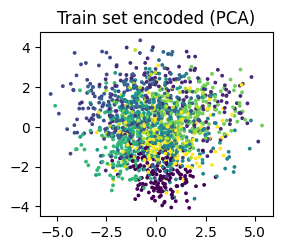

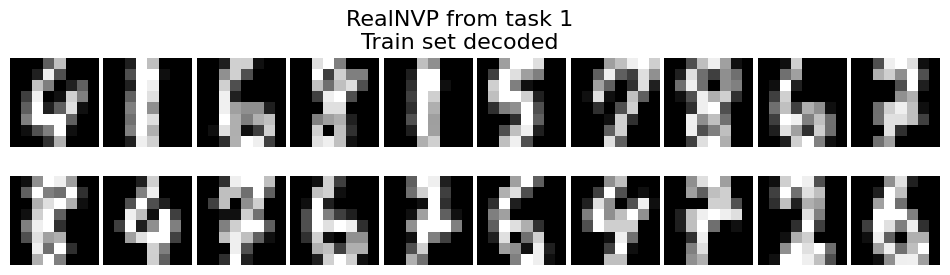

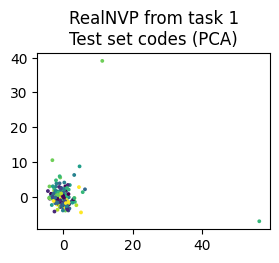

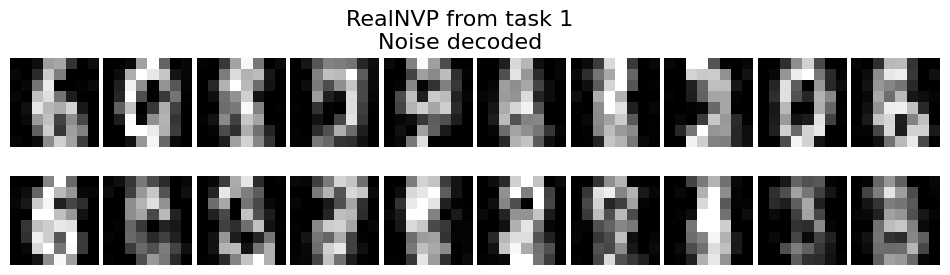

In [45]:
plot_model_details_pca(model, X_train, y_train, X_test, y_test, title="RealNVP from task 1")

In [46]:

def custom_negative_log_likelihood_loss(model_outputs, log_det_jacobian_sum):
    return torch.mean(torch.sum(0.5 * torch.pow(model_outputs, 2), dim=1) - log_det_jacobian_sum)

def custom_reconstruction_loss(model_outputs, original_data):
    return torch.mean(torch.sum(torch.pow(model_outputs - original_data, 2), dim=1))

def train_inn_bottleneck(model, X_train, X_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1, 
              nnl_loss_func=custom_negative_log_likelihood_loss, 
              reconstruction_loss_func=custom_reconstruction_loss, bottleneck_size=8, # Added - bottleneck and reconstruction loss
              reconstruction_loss_weight=1.0): 
    """
    Args:
        model (nn.Module): a RealNVP model which returns z and log_det_jacobian_sum
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        n_epochs (int): the number of training epochs
        batch_size (int): the batch size
        learning_rate (float): the learning rate
        size_of_the_training_set (int): subset of the training set to use (default: -1, i.e. use the whole training set)
        nnl_loss_func (function): the negative log likelihood loss function to use (default: custom_negative_log_likelihood_loss)
    # Added - bottleneck and reconstruction loss
        reconstruction_loss_func (function): the reconstruction loss function to use (default: custom_reconstruction_loss)
        bottleneck_size (int): the size of the bottleneck (default: 2)
        reconstruction_loss_weight (float): the weight of the reconstruction loss (default: 1.0)
    """

    # Added - function to compute (weighted) sum of nll and rconstruction loss that adds bottleneck
    def compute_loss_with_bottleneck(model, X,
                                     nnl_loss_func=nnl_loss_func,
                                     reconstruction_loss_func=reconstruction_loss_func,
                                     bottleneck_size=bottleneck_size,
                                     reconstruction_loss_weight=reconstruction_loss_weight):
        z, log_det_jacobian_sum = model(X)
        nll_loss = nnl_loss_func(z, log_det_jacobian_sum)
        z_bottlenecked = torch.zeros_like(z)
        z_bottlenecked[:, :bottleneck_size] = z[:, :bottleneck_size].clone()
        X_reconstructed = model.decoder(z_bottlenecked)
        reconstruction_loss = reconstruction_loss_func(X_reconstructed, X)
        loss = nll_loss + reconstruction_loss_weight * reconstruction_loss
        return loss, (nll_loss, reconstruction_loss)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    data_test = torch.from_numpy(X_test).float()

    with torch.no_grad():
        loss, (nll_loss_train, reconstruction_loss_train) = compute_loss_with_bottleneck(model, data_train)
        train_losses.append(loss.item())
        loss, (nll_loss_test, reconstruction_loss_test) = compute_loss_with_bottleneck(model, data_test)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")
    print(f"\tTrain: nll_loss={nll_loss_train:.4f}, reconstruction_loss={reconstruction_loss_train:.4f}")
    print(f"\tTest: nll_loss={nll_loss_test:.4f}, reconstruction_loss={reconstruction_loss_test:.4f}")

    # trainning
    for epoch in range(n_epochs):
        train_loss = 0
        train_nll_loss, train_reconstruction_loss = 0, 0
        test_loss = 0
        test_nll_loss, test_reconstruction_loss = 0, 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            optimizer.zero_grad()
            loss, (nll_loss, reconstruction_loss) = compute_loss_with_bottleneck(model, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
            train_nll_loss += nll_loss.item() * len(data)
            train_reconstruction_loss += reconstruction_loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)
        train_nll_loss /= len(X_train)
        train_reconstruction_loss /= len(X_train)

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                loss, (nll_loss, reconstruction_loss) = compute_loss_with_bottleneck(model, data)
                test_loss += loss.item() * len(data)
                test_nll_loss += nll_loss.item() * len(data)
                test_reconstruction_loss += reconstruction_loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
            test_nll_loss /= len(X_test)
            test_reconstruction_loss /= len(X_test)
            
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
            print(f"\tTrain: nll_loss={train_nll_loss:.4f}, reconstruction_loss={train_reconstruction_loss:.4f}")
            print(f"\tTest: nll_loss={test_nll_loss:.4f}, reconstruction_loss={test_reconstruction_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df

In [47]:
def plot_model_details_bottleneck(model, X_train, bottleneck_size):
    data_shape = X_train.shape[1]
    with torch.no_grad():
        Z_random_masked_unimportant = torch.zeros((1000, data_shape))
        Z_random_masked_unimportant[:, :bottleneck_size] =  torch.randn((1000, bottleneck_size))
        X_masked_unimportant = model.decoder(Z_random_masked_unimportant).detach().numpy()

    # plot rows of digits with masked unimportant 
    fig, axs = plt.subplots(9, 20, figsize=(12, 6))
    fig.suptitle(f"Masked unimportant part of z, bottleneck={bottleneck_size}\nImages should be some numbers", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    # choose random len(axs.flat) rows of X_masked_unimportant
    X_masked_unimportant_sample = X_masked_unimportant[np.random.choice(len(X_masked_unimportant), size=len(axs.flat), replace=False)].copy()
    X_masked_unimportant_sample[X_masked_unimportant_sample < 0] = 0
    X_masked_unimportant_sample[X_masked_unimportant_sample > 16] = 16
    for i, axi in enumerate(axs.flat):
        im = axi.imshow(X_masked_unimportant_sample[i].reshape(8, 8), cmap="gray")
        im.set_clim(0, 16)
        axi.axis("off")
    plt.show()

    # plot rows of digits with fixed important
    fig, axs = plt.subplots(9, 20, figsize=(12, 6))
    fig.suptitle(f"Fixed important part of z, bottleneck={bottleneck_size}\nImages in each row should be variations of the same image", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for ax_row in axs:
        with torch.no_grad():
            Z_random_fixed_important = torch.randn((1000, data_shape))
            fixed_part = torch.randn((1000, bottleneck_size))
            Z_random_fixed_important[:, :bottleneck_size] = fixed_part
            X_fixed_important = model.decoder(Z_random_fixed_important).detach().numpy()

        # choose random len(axs.flat) rows of X_fixed_important
        X_fixed_important_sample = X_fixed_important[np.random.choice(len(X_fixed_important), size=len(axs.flat), replace=False)].copy()
        X_fixed_important_sample[X_fixed_important_sample < 0] = 0
        X_fixed_important_sample[X_fixed_important_sample > 16] = 16
        for i, axi in enumerate(ax_row):
            im = axi.imshow(X_fixed_important_sample[i].reshape(8, 8), cmap="gray")
            im.set_clim(0, 16)
            axi.axis("off")
    plt.show()

In [48]:
model = RealNVP(64, 128, 4)
df = train_inn_bottleneck(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=1000, 
               batch_size=64,
               bottleneck_size=8, 
               reconstruction_loss_weight=1,
               learning_rate=0.001)


Epoch 0/1000: train_loss=10166.3506, test_loss=10558.1035
	Train: nll_loss=5888.8887, reconstruction_loss=4277.4619
	Test: nll_loss=6226.1401, reconstruction_loss=4331.9634
Epoch 101/1000: train_loss=234.4475, test_loss=355.7422
	Train: nll_loss=80.5358, reconstruction_loss=153.9118
	Test: nll_loss=88.0314, reconstruction_loss=267.7108
Epoch 202/1000: train_loss=180.9874, test_loss=384.9880
	Train: nll_loss=66.6146, reconstruction_loss=114.3728
	Test: nll_loss=93.6738, reconstruction_loss=291.3142
Epoch 303/1000: train_loss=146.2000, test_loss=411.7410
	Train: nll_loss=57.7531, reconstruction_loss=88.4469
	Test: nll_loss=108.5484, reconstruction_loss=303.1926
Epoch 404/1000: train_loss=129.9768, test_loss=488.8186
	Train: nll_loss=50.5862, reconstruction_loss=79.3905
	Test: nll_loss=135.3435, reconstruction_loss=353.4751
Epoch 505/1000: train_loss=107.3880, test_loss=497.1697
	Train: nll_loss=44.5570, reconstruction_loss=62.8310
	Test: nll_loss=152.2853, reconstruction_loss=344.8844
Ep

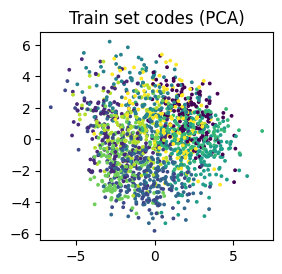

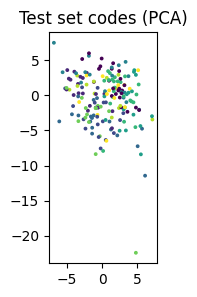

In [49]:
pca_model = PCA(n_components=2)

with torch.no_grad():
    Z_train = model(torch.from_numpy(X_train).float())[0]
    pca_model.fit(Z_train.detach().numpy())
    Z_train_pca = pca_model.transform(Z_train.detach().numpy())

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(Z_train_pca[:, 0], Z_train_pca[:, 1], c=y_train, s=3)
ax.set_title("Train set codes (PCA)")
ax.set_aspect('equal')
plt.show()


with torch.no_grad():
    Z_test = model(torch.from_numpy(X_test).float())[0]
    Z_test_pca = pca_model.transform(Z_test.detach().numpy()) 

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(Z_test_pca[:, 0], Z_test_pca[:, 1], c=y_test, s=3)
ax.set_title("Test set codes (PCA)")
ax.set_aspect('equal')
plt.show()


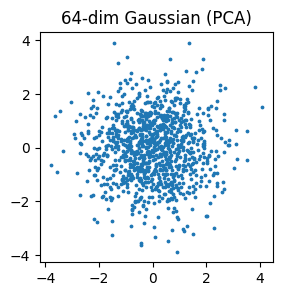

In [50]:
Z_random = torch.randn((1000, X_train.shape[1]))
Z_random_pca = PCA(n_components=2).fit_transform(Z_random.detach().numpy())

fig, ax = plt.subplots(1, 1, figsize=(3,3))
ax.scatter(Z_random_pca[:, 0], Z_random_pca[:, 1], s=3)
ax.set_title("64-dim Gaussian (PCA)")
ax.set_aspect('equal')
plt.show()

Now generate data with this model, with both the unimportant dimensions kept at zero (so
only the first k dimensions are sampled), and with the first k dimensions kept at some fixed
value and sampling the remaining 64 − k dimensions from the standad normal. The former
variant should work similar to the autoencoder from exercise 02, whereas the latter should
add diversity to the generated images, while keeping the general appearance fixed.

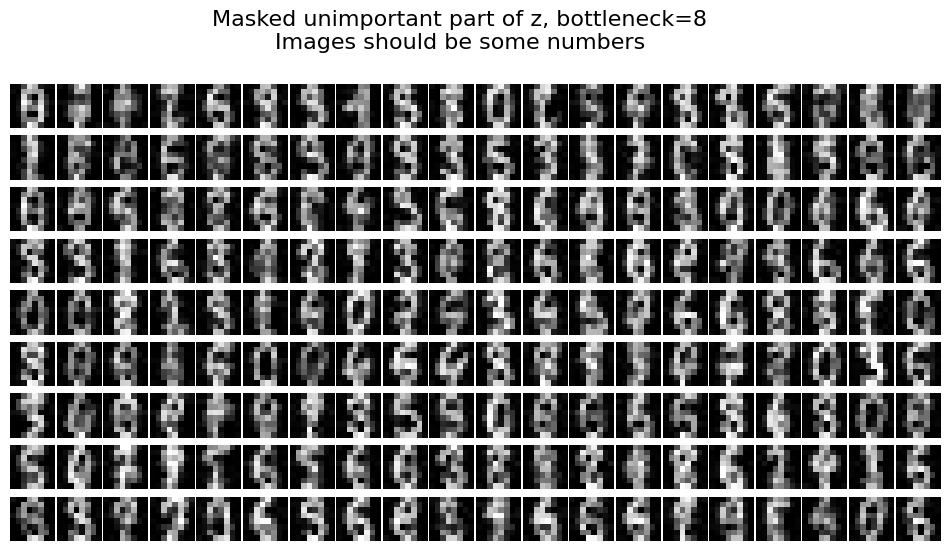

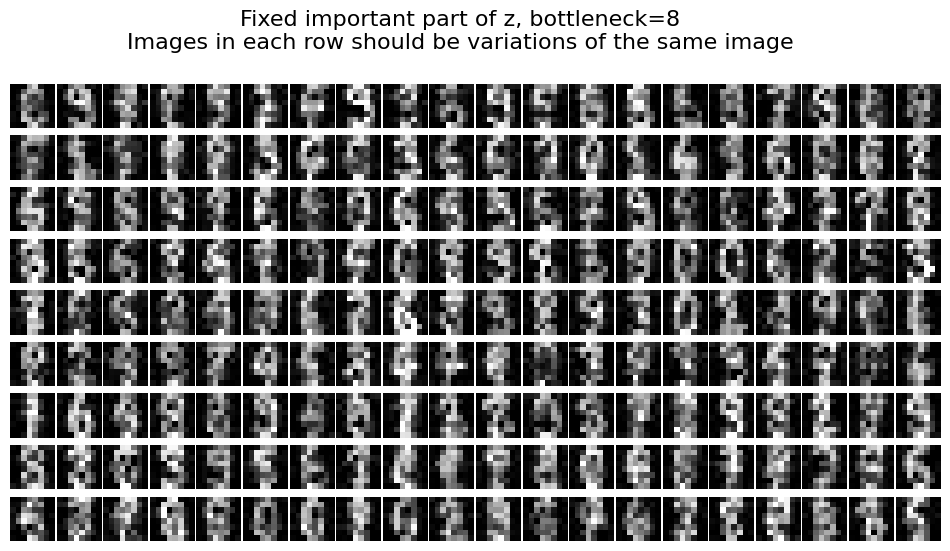

In [51]:
plot_model_details_bottleneck(model, X_train, bottleneck_size=8)

When unimportant parts are also sampled, it takes 13 minutes to obtain barely readable digits after we trained the model for 1000 epochs.

Though the images should only slightly change, the digits in each row are different, indicating that the irrelevant portion of the codes contain too much information.

Experiment with this split method, where codes are categorized into important and unimportant and
report your findings. Does the quality of the synthetic images improve, and do you observe
the expected behavior of the two sampling schemes described above?


In [52]:
trained_model_and_results = {} 

In [53]:
BOTTLENECK = 8

model = RealNVP(64, 128, 4)
df = train_inn_bottleneck(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=100, 
               batch_size=64,
               bottleneck_size=BOTTLENECK, 
               reconstruction_loss_weight=1,
               learning_rate=0.001)
trained_model_and_results[BOTTLENECK] = (model, df)

Epoch 0/100: train_loss=7538.4883, test_loss=7549.4375
	Train: nll_loss=3671.2708, reconstruction_loss=3867.2175
	Test: nll_loss=3644.9351, reconstruction_loss=3904.5022
Epoch 11/100: train_loss=437.5280, test_loss=431.0514
	Train: nll_loss=122.3733, reconstruction_loss=315.1547
	Test: nll_loss=119.9220, reconstruction_loss=311.1294
Epoch 22/100: train_loss=352.7858, test_loss=388.4658
	Train: nll_loss=104.1553, reconstruction_loss=248.6305
	Test: nll_loss=104.1583, reconstruction_loss=284.3075
Epoch 33/100: train_loss=314.5877, test_loss=354.7788
	Train: nll_loss=96.4778, reconstruction_loss=218.1098
	Test: nll_loss=97.5449, reconstruction_loss=257.2339
Epoch 44/100: train_loss=278.7909, test_loss=341.9860
	Train: nll_loss=89.8382, reconstruction_loss=188.9527
	Test: nll_loss=93.5245, reconstruction_loss=248.4614
Epoch 55/100: train_loss=278.4957, test_loss=356.7606
	Train: nll_loss=86.4109, reconstruction_loss=192.0847
	Test: nll_loss=91.4732, reconstruction_loss=265.2874
Epoch 66/10

In [54]:
BOTTLENECK = 4

model = RealNVP(64, 128, 4)
df = train_inn_bottleneck(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=100, 
               batch_size=64,
               bottleneck_size=BOTTLENECK, 
               reconstruction_loss_weight=1,
               learning_rate=0.001)
trained_model_and_results[BOTTLENECK] = (model, df)

Epoch 0/100: train_loss=7970.5752, test_loss=8087.1499
	Train: nll_loss=4079.2942, reconstruction_loss=3891.2810
	Test: nll_loss=4127.4575, reconstruction_loss=3959.6924
Epoch 11/100: train_loss=662.8371, test_loss=651.1331
	Train: nll_loss=130.2217, reconstruction_loss=532.6153
	Test: nll_loss=130.1556, reconstruction_loss=520.9775
Epoch 22/100: train_loss=560.3367, test_loss=588.3958
	Train: nll_loss=115.2173, reconstruction_loss=445.1193
	Test: nll_loss=115.0686, reconstruction_loss=473.3272
Epoch 33/100: train_loss=478.6053, test_loss=539.2254
	Train: nll_loss=105.9842, reconstruction_loss=372.6212
	Test: nll_loss=108.4296, reconstruction_loss=430.7958
Epoch 44/100: train_loss=466.1698, test_loss=547.5003
	Train: nll_loss=102.4956, reconstruction_loss=363.6743
	Test: nll_loss=104.6434, reconstruction_loss=442.8570
Epoch 55/100: train_loss=420.6449, test_loss=486.8071
	Train: nll_loss=97.7901, reconstruction_loss=322.8548
	Test: nll_loss=100.0960, reconstruction_loss=386.7111
Epoch 

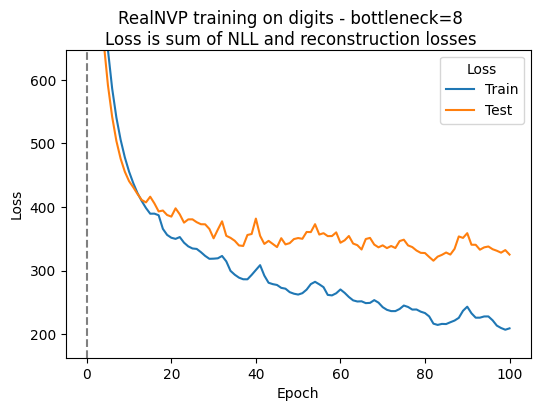

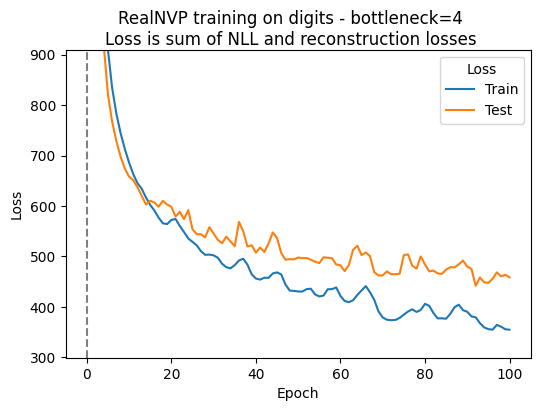

In [55]:
for bottleneck, (model, df) in trained_model_and_results.items():
    title=f"RealNVP training on digits - bottleneck={bottleneck}\nLoss is sum of NLL and reconstruction losses"
    plot_training_losses(df, title=title, starting_epoch=5)

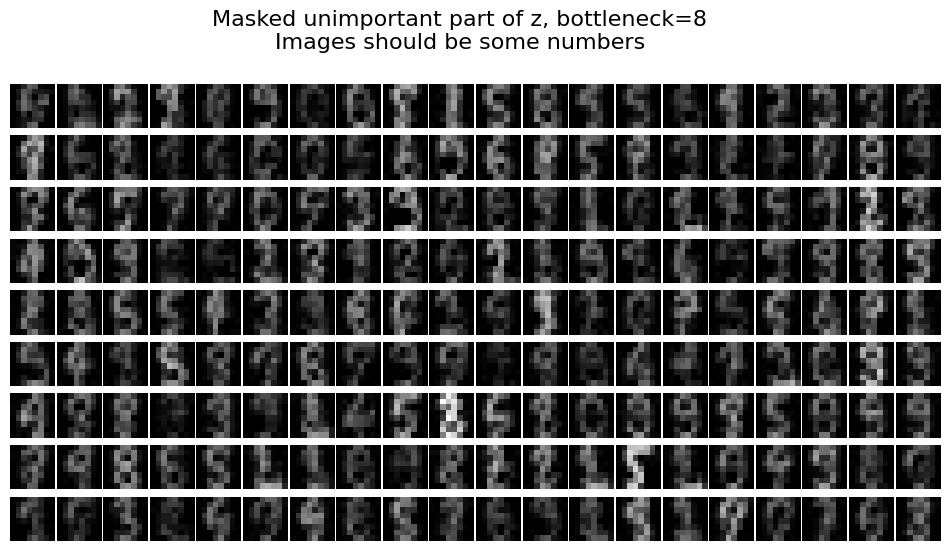

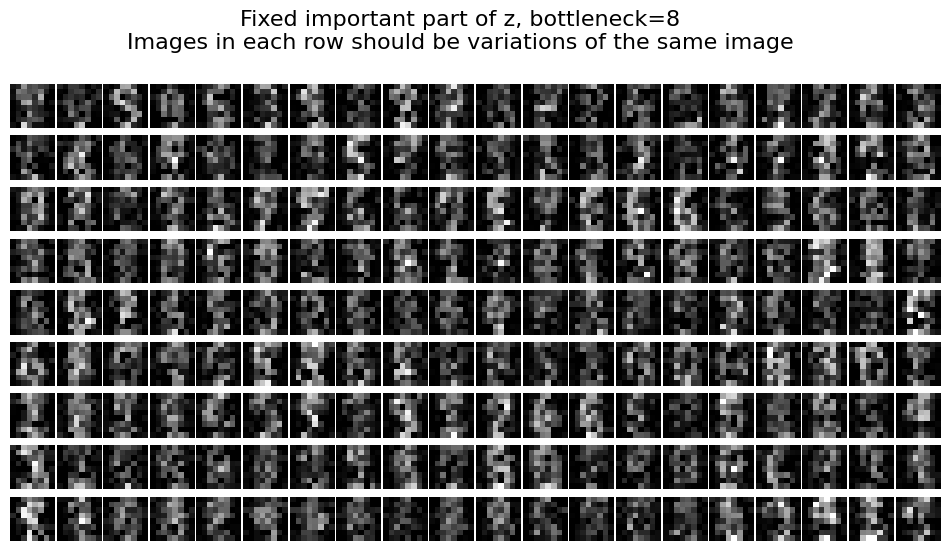

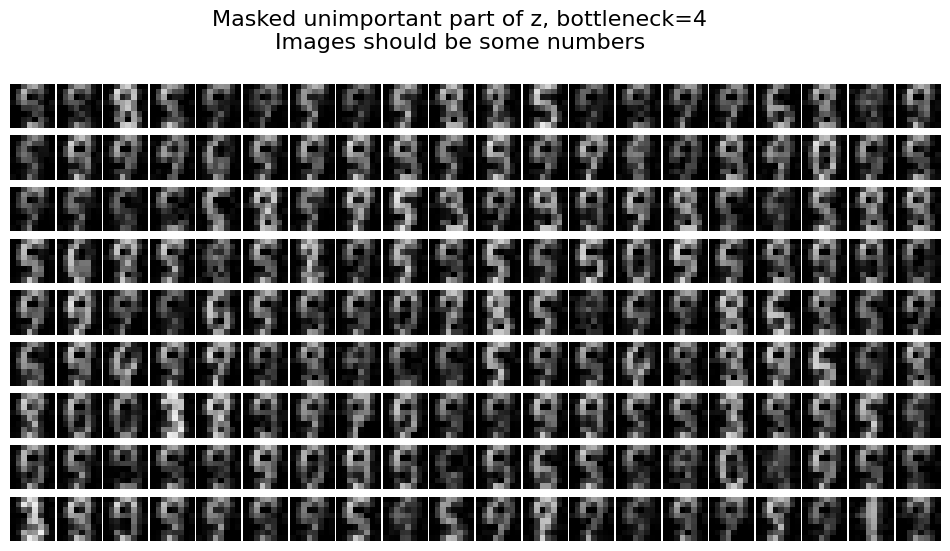

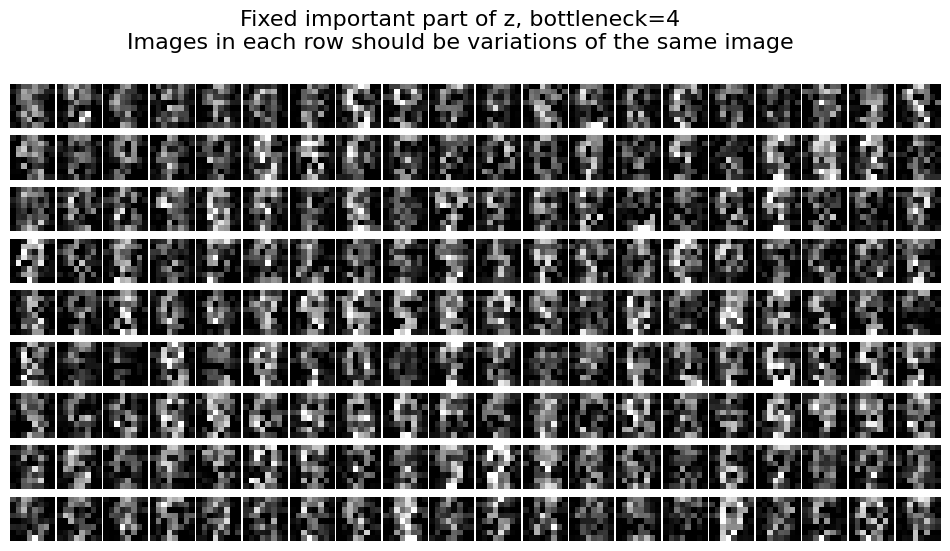

In [56]:
for bottleneck, (model, df) in trained_model_and_results.items():
    plot_model_details_bottleneck(model, X_train, bottleneck_size=bottleneck)

According to training curves, training could be extended to reduce the loss. Nevertheless, overfitting occurs for every bottleneck.

Interestingly, the model with bottleneck 4 has a few more digits that are unclear, while the model with bottleneck 8 is able to sample all of the digits, albeit they are not very readable. 

Q3. Another possibility is to use more training data. The listing below shows how you can import the MNIST digits dataset (which consists of 6000 training instances for each label) and downscale it to 8 × 8 on the fly. Evaluate your RealNVP on this dataset.

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:10<00:00, 976kB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 73.5kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 1.79MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 2.27MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



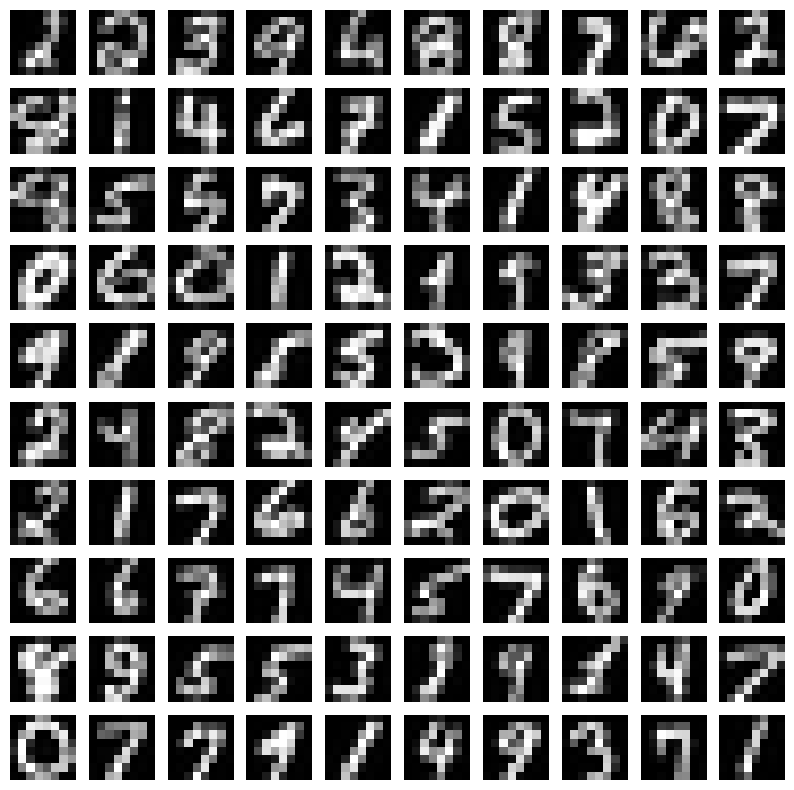

In [57]:


import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, ImageFilter 
import matplotlib.pyplot as plt


class DownsampleTransform:
    def __init__ (self, target_shape, algorithm=Image.Resampling.LANCZOS):
        self.width, self.height = target_shape
        self.algorithm = algorithm

    def __call__ (self, img):
        img = img.resize((self.width+2, self.height+2), self.algorithm)
        img = img.crop((1, 1, self.width+1, self.height+1))
        return img


transform = transforms.Compose([
    DownsampleTransform(target_shape=(8, 8)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    ])

# download MNIST
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# create a DataLoader that serves minibatches of size 100
data_loader = DataLoader(mnist_dataset, batch_size=100, shuffle=True)

# visualize the first batch of downsampled MNIST images
def show_first_batch(data_loader):
    for batch in data_loader:
        x, y = batch
        fig = plt.figure(figsize=(10, 10))
        for i, img in enumerate(x):
            ax = fig.add_subplot(10, 10, i+1)
            ax.imshow(img.reshape(8, 8), cmap='gray')
            ax.axis('off')
        break

show_first_batch(data_loader)

In [58]:
data_loader = DataLoader(mnist_dataset, batch_size=len(mnist_dataset), shuffle=True)
X, y = next(iter(data_loader))
X = X.detach().numpy().reshape(len(mnist_dataset), -1) * 16 
y = y.detach().numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((54000, 64), (54000,), (6000, 64), (6000,))

Epoch 0/3: train_loss=4731.6514, test_loss=4692.7095
Epoch 1/3: train_loss=81.2246, test_loss=50.7772
Epoch 2/3: train_loss=42.9137, test_loss=37.5119
Epoch 3/3: train_loss=32.8357, test_loss=30.3475


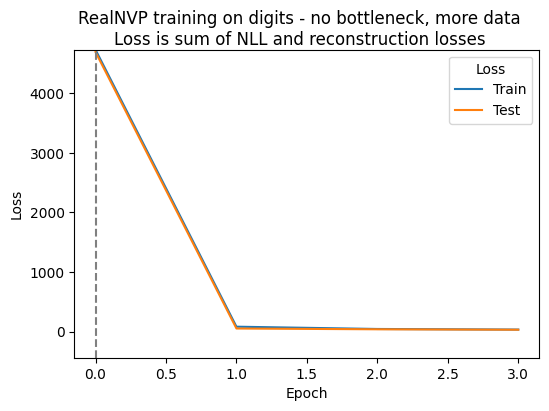

In [59]:
model = RealNVP(64, 128, 8)
df = train_inn(model=model, X_train=X_train, X_test=X_test, 
               n_epochs=3, 
               batch_size=64,
               learning_rate=0.001)

title=f"RealNVP training on digits - no bottleneck, more data\nLoss is sum of NLL and reconstruction losses"
plot_training_losses(df, title=title, starting_epoch=0)

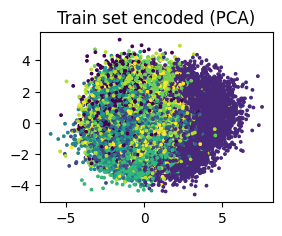

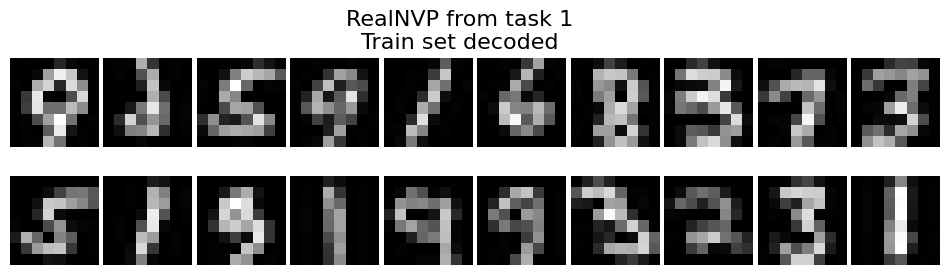

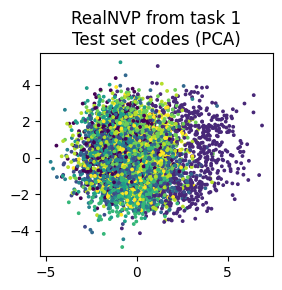

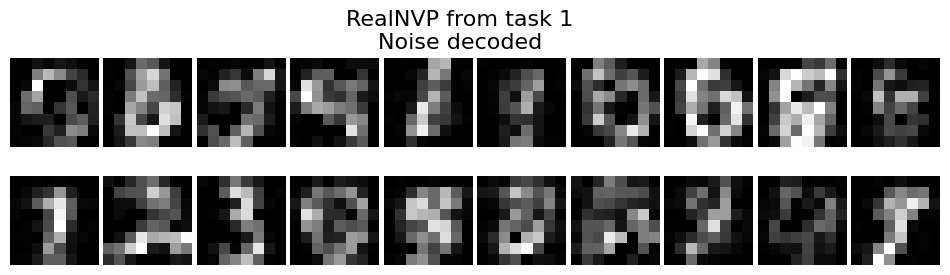

In [60]:
plot_model_details_pca(model, X_train, y_train, X_test, y_test, title="RealNVP from task 1")

The results were not improved by training on more data for the same number of epochs and with the same model architecture. A longer training session would most likely highlight the improvements and differences.


4 Higher-dimensional data with a conditional INN

Repeat task 3 with a conditional RealNVP using the digit labels as a condition. Generate data with
your model for predefined labels. Do the synthetic digits look like examples for the desired digit
label? If yes, you should again check the accuracy and condence with a random forest classifier as
in exercise 02.

In [63]:
def custom_negative_log_likelihood_loss(model_outputs, log_det_jacobian_sum):
    return torch.mean(torch.sum(0.5 * torch.pow(model_outputs, 2), dim=1) - log_det_jacobian_sum)

def custom_reconstruction_loss(model_outputs, original_data):
    return torch.mean(torch.sum(torch.pow(model_outputs - original_data, 2), dim=1))

def train_inn_conditional_bottleneck(model, X_train, X_test, y_train, y_test, n_epochs, batch_size, learning_rate=0.001, size_of_the_training_set=-1, 
                          nnl_loss_func=custom_negative_log_likelihood_loss, 
                          reconstruction_loss_func=custom_reconstruction_loss, bottleneck_size=8, 
                          reconstruction_loss_weight=1.0):
    """
    Args:
        model (nn.Module): a RealNVP model which returns z and log_det_jacobian_sum
        X_train (np.ndarray): the training data
        X_test (np.ndarray): the test data
        y_train (np.ndarray): the training data conditions
        y_test (np.ndarray): the test data conditions
        n_epochs (int): the number of training epochs
        batch_size (int): the batch size
        learning_rate (float): the learning rate
        size_of_the_training_set (int): subset of the training set to use (default: -1, i.e. use the whole training set)
        nnl_loss (function): the negative log likelihood loss function to use (default: custom_negative_log_likelihood_loss)
    # Added - bottleneck and reconstruction loss
        reconstruction_loss (function): the reconstruction loss function to use (default: custom_reconstruction_loss)
        bottleneck_size (int): the size of the bottleneck (default: 2)
        reconstruction_loss_weight (float): the weight of the reconstruction loss (default: 1.0)
    """
    
    def compute_loss_with_bottleneck_conditional(model, X, y_onehotencoded_conditions, 
                                     nnl_loss_func=nnl_loss_func,
                                     reconstruction_loss_func=reconstruction_loss_func,
                                     bottleneck_size=bottleneck_size,
                                     reconstruction_loss_weight=reconstruction_loss_weight):
        z, log_det_jacobian_sum = model(X, y_onehotencoded_conditions)
        nll_loss = nnl_loss_func(z, log_det_jacobian_sum)
       
        z_bottlenecked = torch.zeros_like(z)
        z_bottlenecked[:, :bottleneck_size] = z[:, :bottleneck_size]
        x_reconstructed = model.decoder(z_bottlenecked, y_onehotencoded_conditions)
        reconstruction_loss = reconstruction_loss_func(x_reconstructed, X)
        loss = nll_loss + reconstruction_loss * reconstruction_loss_weight
        return loss, (nll_loss, reconstruction_loss)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    test_losses = []

    X_train = X_train[:size_of_the_training_set]
    y_train = y_train[:size_of_the_training_set]
    
    data_train = torch.from_numpy(X_train).float()
    y_train = torch.from_numpy(y_train).float()
    y_onehotencoded_conditions_train = torch.eye(model.condition_size)[y_train.long()].float()
    data_test = torch.from_numpy(X_test).float()
    y_test = torch.from_numpy(y_test).float()
    y_onehotencoded_conditions_test = torch.eye(model.condition_size)[y_test.long()].float() 

   
    with torch.no_grad():
        loss, (nll_loss_train, reconstruction_loss_train) = compute_loss_with_bottleneck_conditional(model, data_train, y_onehotencoded_conditions_train)
        train_losses.append(loss.item())
        loss, (nll_loss_test, reconstruction_loss_test) = compute_loss_with_bottleneck_conditional(model, data_test, y_onehotencoded_conditions_test)
        test_losses.append(loss.item())
    print(f"Epoch 0/{n_epochs}: train_loss={train_losses[-1]:.4f}, test_loss={test_losses[-1]:.4f}")
    print(f"\tTrain: nll_loss={nll_loss_train:.4f}, reconstruction_loss={reconstruction_loss_train:.4f}")
    print(f"\tTest: nll_loss={nll_loss_test:.4f}, reconstruction_loss={reconstruction_loss_test:.4f}")

    # training
    for epoch in range(n_epochs):
        train_loss = 0
        train_nll_loss, train_reconstruction_loss = 0, 0
        test_loss = 0
        test_nll_loss, test_reconstruction_loss = 0, 0
        for i in range(0, len(X_train), batch_size):
            data = data_train[i:i+batch_size]
            y_data = y_onehotencoded_conditions_train[i:i+batch_size] 
            optimizer.zero_grad()
            loss, (nll_loss, reconstruction_loss) = compute_loss_with_bottleneck_conditional(model, data, y_data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * len(data)
            train_nll_loss += nll_loss.item() * len(data)
            train_reconstruction_loss += reconstruction_loss.item() * len(data)
        train_loss /= len(X_train)
        train_losses.append(train_loss)
        train_nll_loss /= len(X_train)
        train_reconstruction_loss /= len(X_train)

        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                data = data_test[i:i+batch_size]
                y_data = y_onehotencoded_conditions_test[i:i+batch_size] 
                loss, (nll_loss, reconstruction_loss) = compute_loss_with_bottleneck_conditional(model, data, y_data)
                test_loss += loss.item() * len(data)
                test_nll_loss += nll_loss.item() * len(data)
                test_reconstruction_loss += reconstruction_loss.item() * len(data)
            test_loss /= len(X_test)
            test_losses.append(test_loss)
            test_nll_loss /= len(X_test)
            test_reconstruction_loss /= len(X_test)
            
        if (epoch+1) % (n_epochs//10+1) == 0 or epoch == n_epochs-1:
            print(f"Epoch {epoch+1}/{n_epochs}: train_loss={train_loss:.4f}, test_loss={test_loss:.4f}")
            print(f"\tTrain: nll_loss={train_nll_loss:.4f}, reconstruction_loss={train_reconstruction_loss:.4f}")
            print(f"\tTest: nll_loss={test_nll_loss:.4f}, reconstruction_loss={test_reconstruction_loss:.4f}")
    df = pd.DataFrame({'train': train_losses, 'test': test_losses, 'epoch': list(range(n_epochs+1))})
    return df

In [ ]:
def plot_model_details_bottleneck_conditional(model, data_shape, bottleneck_size):
    num_of_classes = model.condition_size
    y = np.arange(num_of_classes).repeat(1000)
    np.random.shuffle(y)
    y_onehotencoded_conditions = torch.eye(num_of_classes)[torch.from_numpy(y).long()].float() # Added - one-hot encode y
    with torch.no_grad():
        Z_random_masked_unimportant = torch.zeros((1000, data_shape))
        Z_random_masked_unimportant[:, :bottleneck_size] =  torch.randn((1000, bottleneck_size))
        X_masked_unimportant = model.decoder(Z_random_masked_unimportant, y_onehotencoded_conditions[:1000]).detach().numpy()

   
    fig, axs = plt.subplots(num_of_classes, 20, figsize=(12, 1+5*(num_of_classes/10)))
    fig.suptitle(f"Masked unimportant part of z, bottleneck={bottleneck_size}\nImages should be some numbers\nEach row was conditioned with same class y", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    X_masked_unimportant[X_masked_unimportant < 0] = 0
    X_masked_unimportant[X_masked_unimportant > 16] = 16
    for row_id, ax_row in enumerate(axs):
        X_class_row_id = X_masked_unimportant[y[:1000] == row_id]
        for i, axi in enumerate(ax_row):
            im = axi.imshow(X_class_row_id[i].reshape(8, 8), cmap="gray")
            im.set_clim(0, 16)
            axi.axis("off")
            if i == 0:
                axi.text(-12, 5, f"y={row_id}", fontsize=16)

    plt.show()

    fig, axs = plt.subplots(num_of_classes, 20, figsize=(12, 1+5*(num_of_classes/10)))
    fig.suptitle(f"Fixed important part of z and randomized rest, bottleneck={bottleneck_size}\nImages in each row should be variations of the same image\nEach row was conditioned with same class y", y=1, fontsize=16)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for row_id, ax_row in enumerate(axs):
        with torch.no_grad():
            y_onehotencoded_row_id_repeated = torch.eye(num_of_classes)[row_id].repeat(100, 1)
            Z_random_fixed_important = torch.randn((100, data_shape))
            fixed_part = torch.randn((100, bottleneck_size))
            Z_random_fixed_important[:, :bottleneck_size] = fixed_part
            X_fixed_important = model.decoder(Z_random_fixed_important, y_onehotencoded_row_id_repeated).detach().numpy()

        X_fixed_important[X_fixed_important < 0] = 0
        X_fixed_important[X_fixed_important > 16] = 16
        for i, axi in enumerate(ax_row):
            im = axi.imshow(X_fixed_important[i].reshape(8, 8), cmap="gray")
            im.set_clim(0, 16)
            axi.axis("off")
            if i == 0:
                axi.text(-12, 5, f"y={row_id}", fontsize=16)
    plt.show()

In [64]:
trained_model_and_results = {} 

In [65]:
BOTTLENECK = 2

model = RealNVP_Conditional(input_size=64, hidden_size=128, blocks=4, condition_size=10)
df = train_inn_conditional_bottleneck(model=model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test,
               n_epochs=100, 
               batch_size=64,
               bottleneck_size=BOTTLENECK,
               reconstruction_loss_weight=1,
               learning_rate=0.001)
trained_model_and_results[BOTTLENECK] = (model, df)

Epoch 0/100: train_loss=4535.1943, test_loss=4538.0698
	Train: nll_loss=2295.9109, reconstruction_loss=2239.2834
	Test: nll_loss=2297.8589, reconstruction_loss=2240.2109
Epoch 11/100: train_loss=440.4435, test_loss=457.8175
	Train: nll_loss=58.3174, reconstruction_loss=382.1262
	Test: nll_loss=59.6790, reconstruction_loss=398.1385
Epoch 22/100: train_loss=418.4450, test_loss=442.0208
	Train: nll_loss=53.7261, reconstruction_loss=364.7188
	Test: nll_loss=55.2898, reconstruction_loss=386.7310
Epoch 33/100: train_loss=409.7036, test_loss=435.8149
	Train: nll_loss=52.5747, reconstruction_loss=357.1289
	Test: nll_loss=54.0488, reconstruction_loss=381.7661
Epoch 44/100: train_loss=405.4820, test_loss=433.5273
	Train: nll_loss=52.3092, reconstruction_loss=353.1727
	Test: nll_loss=53.6919, reconstruction_loss=379.8354


KeyboardInterrupt: 